# Предсказание температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать, установлен максимальный порог метрики МАЕ 6,8 для оценки качества модели на тестовых данных. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).
Заказчик предоставил несколько файлов, полученных из разных источников:
- данные об электродах;
- данные о подаче сыпучих материалов (объём);
- данные о подаче сыпучих материалов (время);
- данные о продувке сплава газом;
- результаты измерения температуры;
- данные о проволочных материалах (объём);
- данные о проволочных материалах (время).

Для реализации поставленнной цели будем действовать по плану:

1. [Загрузим данные и выполним их первичный осмотр.](#шаг_1)
2. [Проведем исследовательский анализ и предобработка данных.](#шаг_2)
3. [Объединеним данные из разных источников в один датафрейм.](#шаг_3)
4. [Подготовим данных для обучения модели.](#шаг_4) 
5. [Oбучим несколько моделей машинного обучения.](#шаг_5)
6. [Выберем лучшую модель и проверим ее качество на тестовой выборке.](#шаг_6)
7. [Сделаем общий вывод и дадим рекомендации заказчику.](#шаг_7)


In [102]:
pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [104]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display,HTML
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as st
import warnings
import shap
from time import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error)
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor

In [105]:
warnings.filterwarnings('ignore')

In [106]:
RANDOM_STATE = 80724

## Загрузка данных <a id="шаг_1"></a>

Загрузим данные и выполним их первичный осмотр.

In [107]:
folder_1 = '/datasets/'
folder_2 = 'C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Final_boss/'
filenames = ['arc_new', 'bulk_new', 'bulk_time_new', 
            'gas_new', 'temp_new', 'wire_new', 'wire_time_new']

In [108]:
def open_csv(filename):
    full_filename = 'data_' + filename + '.csv'
    path_1 = os.path.join(folder_1, full_filename)
    path_2 = os.path.join(folder_2, full_filename)
    
    if os.path.exists(path_1):
        return pd.read_csv(path_1)
    elif os.path.exists(path_2):
        return pd.read_csv(path_2)
    else:
        print(f'Файл {full_filename} не найден в обеих папках.')

In [109]:
for file in filenames:
    globals()[file] = open_csv(file)
    if globals()[file] is not None:
        print(f'Файл data_{file}.csv успешно открыт и присвоен переменной {file}.')

Файл data_arc_new.csv успешно открыт и присвоен переменной arc_new.
Файл data_bulk_new.csv успешно открыт и присвоен переменной bulk_new.
Файл data_bulk_time_new.csv успешно открыт и присвоен переменной bulk_time_new.
Файл data_gas_new.csv успешно открыт и присвоен переменной gas_new.
Файл data_temp_new.csv успешно открыт и присвоен переменной temp_new.
Файл data_wire_new.csv успешно открыт и присвоен переменной wire_new.
Файл data_wire_time_new.csv успешно открыт и присвоен переменной wire_time_new.


In [110]:
for file in filenames:
    print(globals()[file].columns)

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')
Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')
Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')
Index(['key', 'Газ 1'], dtype='object')
Index(['key', 'Время замера', 'Температура'], dtype='object')
Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')
Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')


Переведем столбцы, содержащие информацию о дате и времени, в объект типа datetime.

In [111]:
def conv_datetime(data, columns):
    for column in columns:
        data[column] = pd.to_datetime(data[column], errors='coerce')
    return data

In [112]:
arc_new = conv_datetime(arc_new, ['Начало нагрева дугой', 'Конец нагрева дугой'])
bulk_time_new = conv_datetime(bulk_time_new, bulk_time_new.columns[1:])
temp_new = conv_datetime(temp_new, ['Время замера'])
wire_time_new = conv_datetime(wire_time_new, wire_time_new.columns[1:])

Изучим основную информацию о датафреймах.

In [113]:
def first_view(data, name):
    display(HTML(f'<h2>Сводная информация о датафрейме {name}</h2>'))
    
    display(data.info())
    
    display(HTML(f'<h3>Первые 5 строк:</h3>'))
    display(data.head())
    
    display(HTML(f'<h3>Последние 5 строк:</h3>'))
    display(data.tail())
              
    display(HTML(f'<h3>Количество пропущенных значений в каждом столбце:</h3>'))
    display(data.isna().sum().to_frame(name='Количество пропущенных значений'))
    
    display(HTML(f'<h3>Количество дубликатов:</h3>'))
    display(data.duplicated().sum())
    
    display(HTML(f'<h3>Количество уникальных значений в каждом столбце:</h3>'))
    display(data.nunique().to_frame(name='Количество уникальных значений'))


In [114]:
first_view(arc_new, 'arc_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность  
14871             0.299579  
14872             0.458240  
14873             0.769302  
14874             0.361543  
14875             0.251347

Количество пропущенных значений
key                                                 0
Начало нагрева дугой                                0
Конец нагрева дугой                                 0
Активная мощность                                   0
Реактивная мощность                                 0

0

Количество уникальных значений
key                                             3214
Начало нагрева дугой                           14876
Конец нагрева дугой                            14876
Активная мощность                              13846
Реактивная мощность                            14707

Первый датасет 'arc_new' содержит информацию о работе электродов, времени нагрева дугой и о значениях активной и реактивной мощностей в разные моменты времени. Всего 14876 записей о 3214 партиях. 

In [115]:
first_view(bulk_new, 'bulk_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0

Количество пропущенных значений
key                                    0
Bulk 1                              2877
Bulk 2                              3107
Bulk 3                              1831
Bulk 4                              2115
Bulk 5                              3052
Bulk 6                              2553
Bulk 7                              3104
Bulk 8                              3128
Bulk 9                              3110
Bulk 10                             2953
Bulk 11                             2952
Bulk 12                              679
Bulk 13                             3111
Bulk 14                              323
Bulk 15                              881

0

Количество уникальных значений
key                                3129
Bulk 1                               47
Bulk 2                               15
Bulk 3                              278
Bulk 4                              206
Bulk 5                               55
Bulk 6                              205
Bulk 7                               25
Bulk 8                                1
Bulk 9                               10
Bulk 10                              77
Bulk 11                             101
Bulk 12                             331
Bulk 13                              14
Bulk 14                             284
Bulk 15                             156

Второй датасет 'bulk_new' содержит информацию об объеме подаваемых сыпучих материалов. В нашем распоряжении данные о 3129 партиях и 15 материалах.

In [116]:
first_view(bulk_time_new, 'bulk_time_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

key Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              Bulk 15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

key Bulk 1 Bulk 2              Bulk 3 Bulk 4 Bulk 5  \
3124  3237    NaT    NaT 2019-09-06 11:54:15    NaT    NaT   
3125  3238    NaT    NaT 2019-09-06 12:26:52    NaT    NaT   
3126  3239    NaT    NaT                 NaT    NaT    NaT   
3127  3240    NaT    NaT                 NaT    NaT    NaT   
3128  3241    NaT    NaT                 NaT    NaT    NaT   

                  Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
3124                 NaT    NaT    NaT    NaT     NaT     NaT   
3125                 NaT    NaT    NaT    NaT     NaT     NaT   
3126 2019-09-06 15:06:00    NaT    NaT    NaT     NaT     NaT   
3127 2019-09-06 16:24:28    NaT    NaT    NaT     NaT     NaT   
3128                 NaT    NaT    NaT    NaT     NaT     NaT   

                 Bulk 12 Bulk 13             Bulk 14             Bulk 15  
3124 2019-09-06 11:49:45     NaT 2019-09-06 11:45:22 2019-09-06 11:40:06  
3125 2019-09-06 12:18:35     NaT 2019-09-06 12:31:49 2019-09-06 12:26:52  
3126 2019-09-06 15:01:44     NaT 2019-09-06 14:58:15 2019-09-06 14:48:06  
3127                 NaT     NaT 2019-09-06 16:07:29 2019-09-06 16:01:34  
3128                 NaT     NaT 2019-09-06 17:26:33 2019-09-06 17:23:15

Количество пропущенных значений
key                                    0
Bulk 1                              2877
Bulk 2                              3107
Bulk 3                              1831
Bulk 4                              2115
Bulk 5                              3052
Bulk 6                              2553
Bulk 7                              3104
Bulk 8                              3128
Bulk 9                              3110
Bulk 10                             2953
Bulk 11                             2952
Bulk 12                              679
Bulk 13                             3111
Bulk 14                              323
Bulk 15                              881

0

Количество уникальных значений
key                                3129
Bulk 1                              252
Bulk 2                               22
Bulk 3                             1298
Bulk 4                             1014
Bulk 5                               77
Bulk 6                              576
Bulk 7                               25
Bulk 8                                1
Bulk 9                               19
Bulk 10                             176
Bulk 11                             177
Bulk 12                            2450
Bulk 13                              18
Bulk 14                            2806
Bulk 15                            2248

В третьейм датасете 'bulk_time_new' содержится информация о времени подачи сыпучих материалов для 3129 партий, количество пропусков совпадает с датасетом bulk_time.

In [117]:
first_view(gas_new, 'gas_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key      Газ 1
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

Количество пропущенных значений
key                                  0
Газ 1                                0

0

Количество уникальных значений
key                              3239
Газ 1                            3239

В датасете 'gas_new' приведена информация об объеме подаваемого инертного газа для обдува стали 3239 партий.

In [118]:
first_view(temp_new, 'temp_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

key        Время замера  Температура
18087  3241 2019-09-06 16:55:01          NaN
18088  3241 2019-09-06 17:06:38          NaN
18089  3241 2019-09-06 17:21:48          NaN
18090  3241 2019-09-06 17:24:44          NaN
18091  3241 2019-09-06 17:30:05          NaN

Количество пропущенных значений
key                                         0
Время замера                                0
Температура                              3427

0

Количество уникальных значений
key                                     3216
Время замера                           18092
Температура                              172

In [119]:
print(f'Временной диапазон наблюдений: {temp_new["Время замера"].min()} - {temp_new["Время замера"].max()}')

Временной диапазон наблюдений: 2019-05-03 11:02:04 - 2019-09-06 17:30:05


В датасете 'temp_new' содержатся 18092  строк с измерения температуры для 3216 партий для разных моментов времени, при этом для 3427 записей температура не указана. Признак температуры будет целевым для нас - именно для прогнозирования этого значения нам необходимо построить модель.

In [120]:
first_view(wire_new, 'wire_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

key      Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
3076  3237   38.088959     NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799     NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761     NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400     NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595     NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN

Количество пропущенных значений
key                                   0
Wire 1                               26
Wire 2                             2002
Wire 3                             3018
Wire 4                             3067
Wire 5                             3080
Wire 6                             3008
Wire 7                             3070
Wire 8                             3062
Wire 9                             3052

0

Количество уникальных значений
key                               3081
Wire 1                            2251
Wire 2                             713
Wire 3                              56
Wire 4                              14
Wire 5                               1
Wire 6                              69
Wire 7                              10
Wire 8                              13
Wire 9                              25

Датасет wire_new содержит информацию об объеме подаваемых проволочных материалов для 3081 партий, при этом только Wire 1 используется достаточно часто, так, например применение Wire 5 мы встречаем только в 1 случае.

In [121]:
first_view(wire_time_new, 'wire_time_new')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

key              Wire 1              Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  Wire 7 Wire 8 Wire 9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

key              Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7  \
3076  3237 2019-09-06 11:33:38    NaT    NaT    NaT    NaT    NaT    NaT   
3077  3238 2019-09-06 12:18:35    NaT    NaT    NaT    NaT    NaT    NaT   
3078  3239 2019-09-06 14:36:11    NaT    NaT    NaT    NaT    NaT    NaT   
3079  3240 2019-09-06 15:33:55    NaT    NaT    NaT    NaT    NaT    NaT   
3080  3241 2019-09-06 17:10:06    NaT    NaT    NaT    NaT    NaT    NaT   

     Wire 8 Wire 9  
3076    NaT    NaT  
3077    NaT    NaT  
3078    NaT    NaT  
3079    NaT    NaT  
3080    NaT    NaT

Количество пропущенных значений
key                                   0
Wire 1                               26
Wire 2                             2002
Wire 3                             3018
Wire 4                             3067
Wire 5                             3080
Wire 6                             3008
Wire 7                             3070
Wire 8                             3062
Wire 9                             3052

0

Количество уникальных значений
key                               3081
Wire 1                            3055
Wire 2                            1079
Wire 3                              63
Wire 4                              14
Wire 5                               1
Wire 6                              73
Wire 7                              11
Wire 8                              19
Wire 9                              29

В датасет wire_time_new содержится информация о времени подачи проволочных материалов.

**ВЫВОД:**



Успешно загрузив файлы, предоставленные заказчиком, мы изучили их содержание. В части датасетов содержится информация о времени проведения технологических процессов для каждой партии, так, например, нам известно время начала и завершения каждого цикла нагрева с указанием потребляемой мощности, замеров температуры и подачи примесей. В другой части данных мы находим количественные характеристики: объем поданных сыпучих материалов,проволоки и инертного газа. Обращает на себя внимание стиль оформления названий столбцов, лучше привести их к единообразию: используем одинаковый регистр и латиницу, пробелы заменим на нижние подчеркивания. Для упрощения обучения модели мы можем создать новый признак - полная мощность - на основании имеющейся информации об активной и реактивной мощностях. Количество уникальных номеров партий не совпадает по файлам, требуется дополнительное изучение на этапе исследовательского анализа, чтобы установить причину отсутствия записей по партиям. Отдельно стоит рассмотреть неравномерность распределения записей по добавке легирующих материалов, в некоторых столбцах содержится запись только об одной операции. Пропуски в данных о подаче материалов можно объяснить отсутствием факта добавления, в таком случае можно заполнить отсутствующие значение нулями. 

## Исследовательский анализ и предобработка данных <a id="шаг_2"></a>

Начнем с изменения названий столбцов.

In [122]:
def new_column_names(data):
    data = data.rename(columns=lambda x: x.replace(' ', '_').lower())
    return data

In [123]:
arc_new.columns = ['key', 'start_heating', 'stop_heating', 'active_power', 'reactive_power']
bulk_new = new_column_names(bulk_new)
bulk_time_new = new_column_names(bulk_time_new)
gas_new.columns = ['key', 'gas_1']
temp_new.columns = ['key', 'measure_time', 'temperature']
wire_new = new_column_names(wire_new)
wire_time_new = new_column_names(wire_time_new)

In [124]:
for file in filenames:
    print(globals()[file].columns)

Index(['key', 'start_heating', 'stop_heating', 'active_power',
       'reactive_power'],
      dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'gas_1'], dtype='object')
Index(['key', 'measure_time', 'temperature'], dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


### Данные об электродах

Изучим датасет arc_new.

In [125]:
arc_new.drop(columns='key').describe().T

count      mean       std         min       25%       50%  \
active_power    14876.0  0.662752  0.258885    0.223120  0.467115  0.599587   
reactive_power  14876.0  0.438986  5.873485 -715.479924  0.337175  0.441639   

                     75%       max  
active_power    0.830070  1.463773  
reactive_power  0.608201  1.270284

Сразу обращает на себя внимание минимальное значение реактивной мощности: очевидно, оно далеко выходит за пределы нормального диапазона значений. Ошибка могла вознинуть на этапе сбора данных, рассмотрим минимальные значения в этом столбце и проверим партию, в которой встречается аномалия. 

In [126]:
arc_new.sort_values(by='reactive_power').head()

key       start_heating        stop_heating  active_power  \
9780   2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   
709     152 2019-05-09 11:26:58 2019-05-09 11:29:41      0.228852   
3290    711 2019-05-31 07:16:01 2019-05-31 07:20:05      0.242989   
11794  2567 2019-08-13 05:51:16 2019-08-13 05:52:22      0.288314   
6130   1336 2019-06-22 15:46:26 2019-06-22 15:47:50      0.244191   

       reactive_power  
9780      -715.479924  
709          0.153777  
3290         0.153921  
11794        0.155221  
6130         0.156525

Действительно, реактивная мощность в партии 2116 сильно отличается от минимальных значений всего датасета. Чтобы не нарушать целостность данных, заменим аномалию на более правдоподобное значение.

In [127]:
arc_new.query('key == 2116')

key       start_heating        stop_heating  active_power  \
9778  2116 2019-07-28 02:07:12 2019-07-28 02:09:14      0.787549   
9779  2116 2019-07-28 02:13:10 2019-07-28 02:15:25      0.580263   
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   
9781  2116 2019-07-28 02:29:11 2019-07-28 02:30:18      0.563641   

      reactive_power  
9778        0.693881  
9779        0.411498  
9780     -715.479924  
9781        0.408513

Кроме проблемной записи в нашем распоряжении есть еще три операции нагрева, на основании которых мы можем определить зависимость между активной и реактивной мощностями. Для этого воспользуемся моделью линейной регрессии и определим интерсепт и коэффициент регрессии.  

In [128]:
arc_key_2116 = arc_new.query('key == 2116 and reactive_power > 0')

Сначала построим график прямой, которая будет стремится проходить через все известные значения.

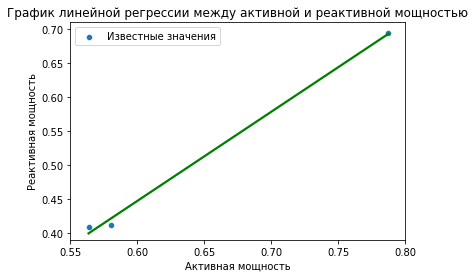

In [129]:
plt.figure(figsize=(6, 4))

sns.scatterplot(x='active_power', y='reactive_power', 
                data=arc_key_2116,
                label='Известные значения')
sns.regplot(x='active_power', y='reactive_power', 
            data=arc_key_2116, 
            scatter=False, color='green', ci=None)
plt.xlim(0.55, 0.8)
plt.ylim(0.39, 0.71)
plt.title('График линейной регрессии между активной и реактивной мощностью')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность')
plt.show()

Всего три точки, но они лежат близко к прямой, можно предположить, что между мощностями существует линейная зависимость. 

In [130]:
X = arc_key_2116['active_power']
y = arc_key_2116['reactive_power']
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()
intercept, slope = model.params

print(f'Уравнение линейной регрессии: y = {intercept:.2f} + {slope:.2f} * x')

Уравнение линейной регрессии: y = -0.34 + 1.31 * x


Подставим известное нам значение активной мощности в полученное уравнение, чтобы избавиться от аномалии.

In [131]:
arc_new.loc[9780, 'reactive_power'] = intercept + slope * arc_new.loc[9780]['active_power']

In [132]:
arc_new.query('key == 2116')

key       start_heating        stop_heating  active_power  \
9778  2116 2019-07-28 02:07:12 2019-07-28 02:09:14      0.787549   
9779  2116 2019-07-28 02:13:10 2019-07-28 02:15:25      0.580263   
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   
9781  2116 2019-07-28 02:29:11 2019-07-28 02:30:18      0.563641   

      reactive_power  
9778        0.693881  
9779        0.411498  
9780        0.585332  
9781        0.408513

Замена произошла корректно.

Теперь мы можем изучить распределение признаков, описывающих мощность. 

In [133]:
def dif_graphics(data, name):
    display(HTML(f'<h2>Статистический анализ датафрейма {name}</h2>'))
    
    numeric_data = data.drop(columns='key').select_dtypes(include=['number'])
    
    display(HTML(f'<h3>Сводная статистика:</h3>'), numeric_data.describe().T)
    
    for column in numeric_data:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        sns.histplot(numeric_data[column], kde=True, bins=100, ax=axes[0], color='salmon')
        axes[0].set_title(f'Гистограмма распределения {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Количество')
        
        sns.boxplot(x=numeric_data[column], ax=axes[1], color='pink')
        axes[1].set_title(f'Boxplot для столбца {column}')
        axes[1].set_xlabel(column)
        
        st.probplot(numeric_data[column], dist='norm', plot=axes[2])
        axes[2].set_title(f'Q-Q plot для столбца {column}')
        
        plt.tight_layout()
        plt.show()
        
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_data.corr(method='spearman'), annot=True, cmap='Blues', alpha=0.7, fmt=".2f")
    plt.title('Матрица корреляций признаков (метод Спирмена)')
    plt.show()
    
    sns.pairplot(numeric_data)
    plt.suptitle('Графики рассеяния признаков', y=1.02)
    plt.show()

count      mean       std       min       25%       50%  \
active_power    14876.0  0.662752  0.258885  0.223120  0.467115  0.599587   
reactive_power  14876.0  0.487122  0.197607  0.153777  0.337192  0.441667   

                     75%       max  
active_power    0.830070  1.463773  
reactive_power  0.608201  1.270284

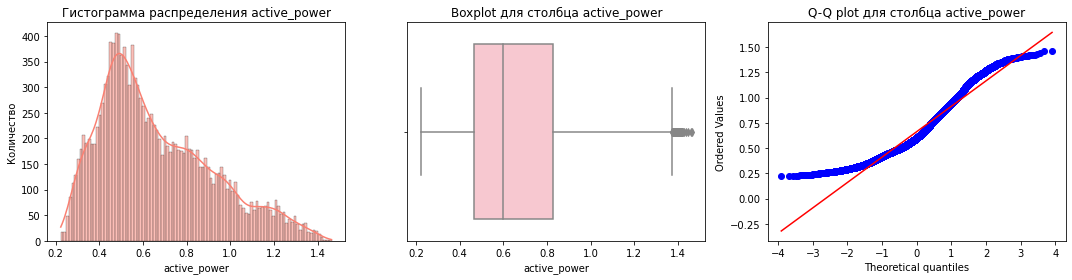

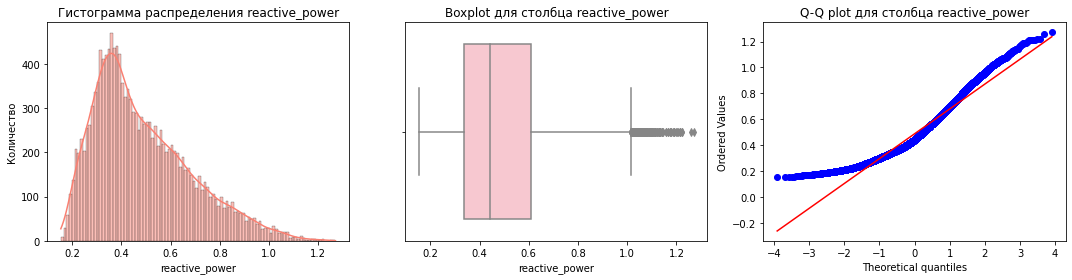

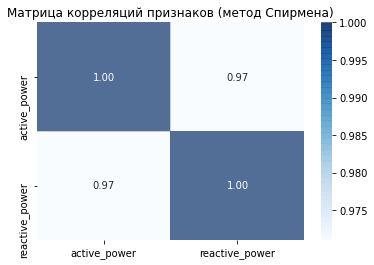

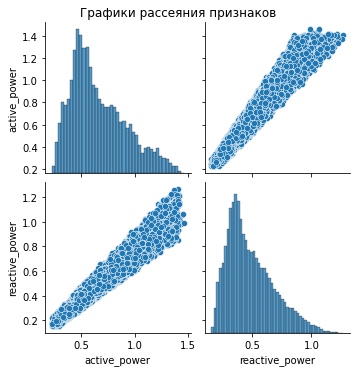

In [134]:
dif_graphics(arc_new, 'arc_new')

Гистограммы распределения этих признаков ассиметричны, напоминают графики гамма распределения, с длинными хвостами справа, в 75% случаев значения активной мощности не превышают показатель 0,83 Вт, а реактивной - 0,61 вар. Чаще всего активная мощность примает значение 0,5 KВт при среднем 0,66 KВт, а реактивная - 0,38 KВАр при среднем 0,49 KВАр. На графиках боксплот наблюдаем небольшие выбросы на верхах графиков, но судя по всему они являются частью реального распределения и содержат важную информацию.

Между активной и реактивной мощностями наблюдается сильная корреляции, между ними есть линейная зависимость. Для обучения модели линейной регрессии мы должны избегать такой степени мультиколлинеарности признаков, попробуем их скомбинировать. Имея представление о двух видах мощностей, мы можем установить размер полной мощности. Активная мощность обозначается буквой P. Реактивной называется мощность, которая потребляется и затем возвращается нагрузкой из-за её реактивных свойств. Реактивная мощность обозначается буквой Q. Так, активная мощность характеризует ту часть электрической энергии, которая преобразуется в другой вид энергии (в свет, тепло, механическую работу), а реактивная мощность характеризует ту часть электрической энергии, которая колеблется между источником электрической энергии и приемником. В случае линейной (равномерной на протяжении периода) нагрузки полная мощность равна корню квадратному из суммы квадратов активной и реактивной мощности. В этом случае неактивная мощность полностью состоит из реактивной составляющей.

Используя формулу

S = √(P² + Q²),

создадим новый признак - полную мощность.

In [135]:
arc_new['apparent_power'] = (arc_new['active_power']**2 + arc_new['reactive_power']**2)**0.5

Также нам может быть полезна информация о том, сколько времени в секундах было затрачено на каждую итерацию, добавим и этот признак.

In [136]:
arc_new['heating_period'] = (arc_new['stop_heating'] - arc_new['start_heating']).dt.total_seconds()

In [137]:
arc_new.head()

key       start_heating        stop_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   apparent_power  heating_period  
0        0.371123           228.0  
1        0.902319           185.0  
2        0.722536           172.0  
3        0.642824           365.0  
4        1.079934           148.0

Добавим коэффициент мощности (cos φ), используя формулу:

cosφ= S / P
​


In [138]:
arc_new['power_coef'] = arc_new['apparent_power'] / arc_new['active_power']

Более высокий коэффициент мощности будет свидетельствовать о более эффективном использовании энергии.

Пригодится и потребленная активная энергия:

𝐸 = 𝑃 * 𝑡,
где 𝑡 - время работы нагревателя в часах.

In [139]:
arc_new['active_energy'] = arc_new['active_power'] * (arc_new['heating_period']/3600)

Теперь сагрегируем информацию по партиям: для каждой оставим среднее значение полной мощности, коэффициента мощности, потребленной энергии и времени нагрева, а также количество операций нагревания.

In [140]:
arc_new_pivot = pd.pivot_table(arc_new, values=['apparent_power', 'power_coef', 'active_energy', 'heating_period'], 
                                index=['key'], 
                                aggfunc=np.mean)
arc_new_pivot['heating_count'] = arc_new.groupby('key').size()
arc_new_pivot.reset_index(inplace=True)
arc_new_pivot.rename(columns={
    'apparent_power': 'mean_apparent_power',
    'power_coef': 'mean_power_coef',
    'active_energy': 'mean_active_energy',
    'heating_period': 'mean_heating_period'
}, inplace=True)

In [141]:
arc_new_pivot.head()

key  mean_active_energy  mean_apparent_power  mean_heating_period  \
0    1            0.034923             0.743747               219.60   
1    2            0.027450             0.647087               202.75   
2    3            0.032321             1.003845               131.00   
3    4            0.037758             0.850010               185.25   
4    5            0.028624             0.704245               217.25   

   mean_power_coef  heating_count  
0         1.225008              5  
1         1.213116              4  
2         1.236957              5  
3         1.259802              4  
4         1.256356              4

count        mean        std        min         25%  \
mean_active_energy   3214.0    0.031739   0.010875   0.005763    0.024116   
mean_apparent_power  3214.0    0.821571   0.160111   0.331897    0.711251   
mean_heating_period  3214.0  172.339290  45.606667  57.000000  140.000000   
mean_power_coef      3214.0    1.242309   0.021929   1.166803    1.227010   
heating_count        3214.0    4.628500   1.608647   1.000000    4.000000   

                            50%         75%         max  
mean_active_energy     0.030182    0.038127    0.111858  
mean_apparent_power    0.812409    0.916602    1.572238  
mean_heating_period  168.750000  200.383333  380.000000  
mean_power_coef        1.241137    1.256196    1.351762  
heating_count          4.000000    6.000000   16.000000

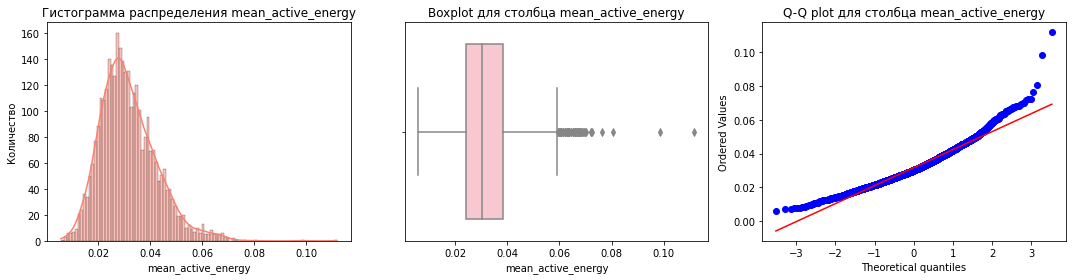

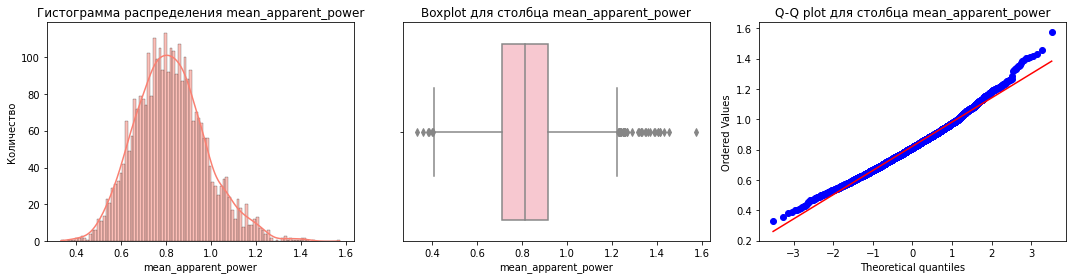

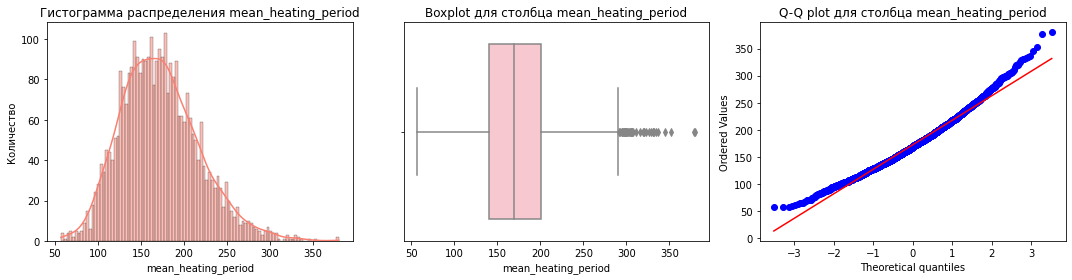

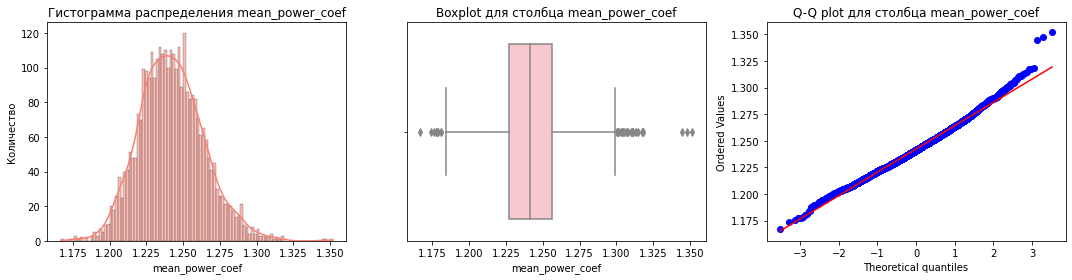

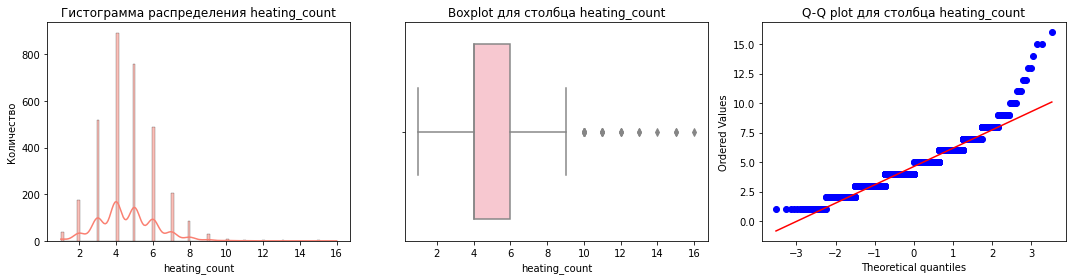

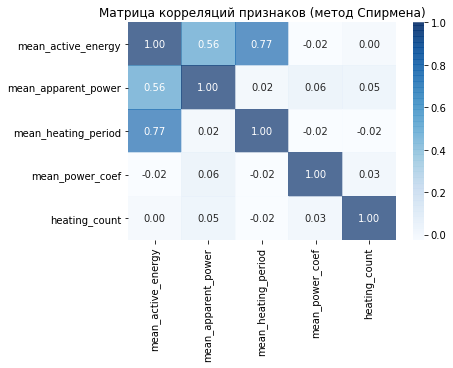

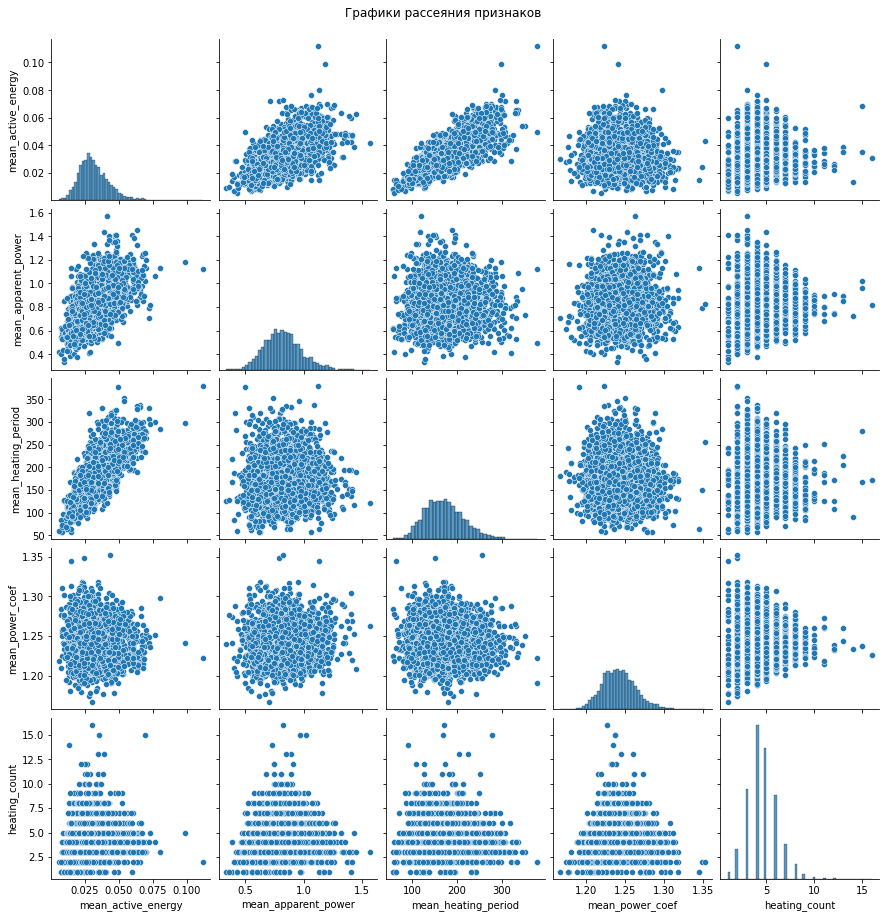

In [142]:
dif_graphics(arc_new_pivot, 'arc_new_pivot')

Количество операций нагрева принимает значения из небольшого диапазона - от 2 до 16 операций. Нам удалось Создать несколько новых информативных признаков.

### Данные о сыпучих материалах

Теперь изучим датафрейм bulk_new. Как мы уже установили, он содержит множество пропущенных значений, которые по существу являются фактом неиспользования материала, поэтому заменим пропуски на 0. Также нам известно, что чаще всего используются сыпучие материалы Bulk 14, Bulk 12 и Bulk 15, остальные используются относительно редко. Анализ текущего состава признаков не будет информативен из-за недостатка данных. Следовательно, чтобы передать модели полезную информацию, нам потребуется создать новые признаки: общий объем добавок и их количество. 

In [143]:
bulk_new.fillna(0, inplace=True)

In [144]:
bulk_new['bulks_total'] = bulk_new.drop(columns='key').sum(axis=1)

In [145]:
bulk_new['bulks_amount'] = bulk_new.drop(columns=['key', 'bulks_total']).apply(lambda x: (x != 0).sum(), axis=1)

In [146]:
bulk_new.sample(3)

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
1959  2027     0.0     0.0    82.0     0.0     0.0    59.0     0.0     0.0   
1492  1549     0.0     0.0     0.0   110.0     0.0     0.0     0.0     0.0   
2014  2085     0.0     0.0     0.0   177.0     0.0     0.0     0.0     0.0   

      bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
1959     0.0      0.0    114.0      0.0      0.0    249.0      0.0   
1492     0.0      0.0      0.0      0.0      0.0    150.0      0.0   
2014     0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      bulks_total  bulks_amount  
1959        504.0             4  
1492        260.0             2  
2014        177.0             1

Добавление признаков прошло корректно, рассмотрим какие материалы используются в большем объеме, а какие - чаще.

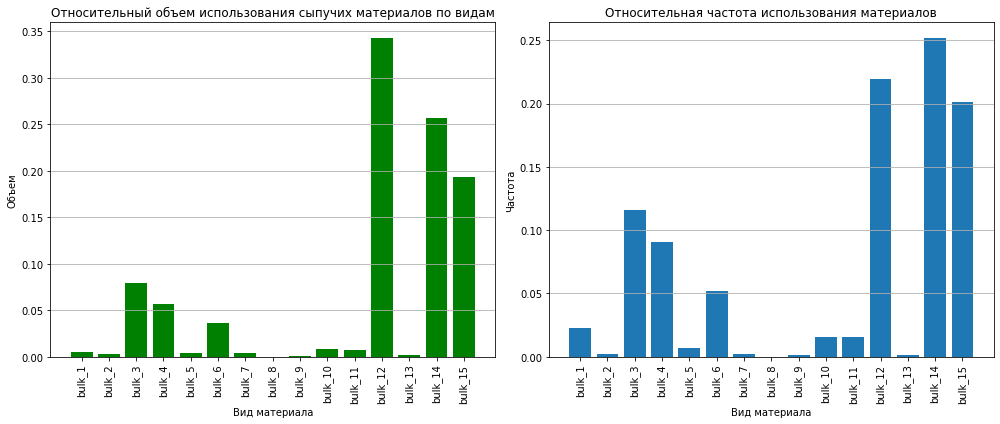

In [147]:
bulk_freq = bulk_new.iloc[:, 1:-2].astype(bool).sum(axis=0)
bulk_sums = bulk_new.iloc[:, 1:-2].sum()
relat_bulk_freq = bulk_freq/bulk_freq.sum()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar((bulk_sums/bulk_sums.sum()).index, (bulk_sums/bulk_sums.sum()).values, color='green')
axes[0].set_title('Относительный объем использования сыпучих материалов по видам')
axes[0].set_xlabel('Вид материала')
axes[0].set_ylabel('Объем')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, axis='y')

axes[1].bar(relat_bulk_freq.index, relat_bulk_freq.values)
axes[1].set_title('Относительная частота использования материалов')
axes[1].set_xlabel('Вид материала')
axes[1].set_ylabel('Частота')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Некоторая корреляция объема и частоты присутствует. 80% всего объема сыпучих материалов составляют bulk_12, bulk_14 и bulk_15. Чаще всего используется bulk_14: в 25% всех случаев добавления материалов, но почти 35% всего объема используемых материалов - bulk_12, он используется реже, но в большем количестве.

Создадим новый столбец с суммой объемов материалов, которые используются реже всего (частота использования меньше 2%).

In [148]:
rarest_bulks = relat_bulk_freq[relat_bulk_freq < 0.02].index

In [149]:
rarest_bulks

Index(['bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_13'],
      dtype='object')

In [150]:
bulk_new['bulk_rare'] = bulk_new[rarest_bulks].sum(axis=1)

count        mean         std   min    25%    50%    75%  \
bulks_total   3129.0  595.503356  276.557794  19.0  429.0  591.0  772.0   
bulks_amount  3129.0    3.566315    1.216165   1.0    3.0    4.0    4.0   

                 max  
bulks_total   3235.0  
bulks_amount     7.0

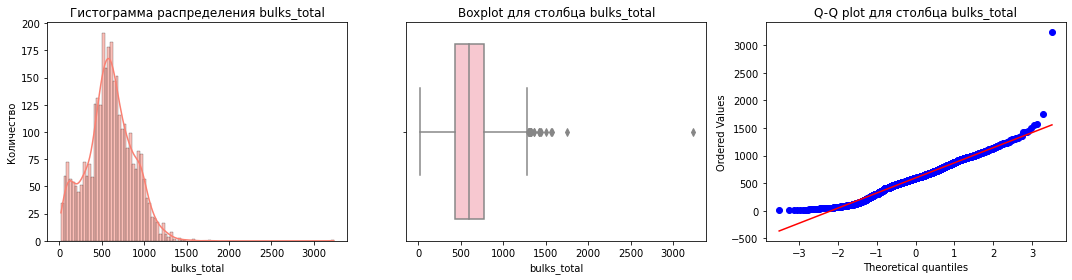

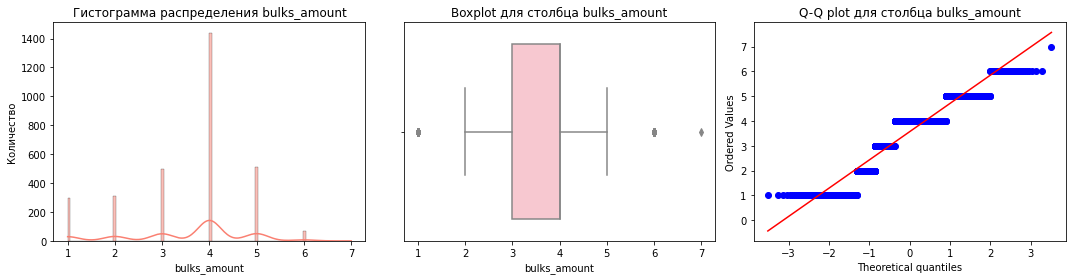

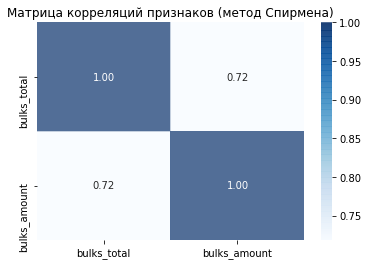

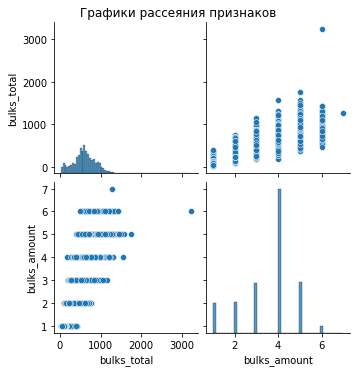

In [151]:
dif_graphics(bulk_new[['key','bulks_total', 'bulks_amount']], 'bulk_new')

И в объеме и в количестве используемых материалов сразу обращает на себя внимание наличие одного крупного выброса, надо рассмотреть их подробнее. Количество добавленных материалов принимает значения из диапазона 1-7, это значит, что нет ни одной партии, которая использовала бы все 15 добавок, а в большинстве случаев, добавляются 2-5 видов.

In [152]:
bulk_new.query('bulks_total >= 3000 or bulks_amount > 6')

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
303    322   185.0     0.0   101.0    58.0     0.0     0.0   406.0     0.0   
1699  1759    46.0     0.0   212.0     0.0    33.0   121.0     0.0     0.0   

      bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
303      0.0      0.0      0.0   1849.0      0.0    636.0      0.0   
1699     0.0      0.0      0.0    410.0      0.0    251.0    205.0   

      bulks_total  bulks_amount  bulk_rare  
303        3235.0             6      406.0  
1699       1278.0             7       33.0

Два редких случая действительно похожи на выбросы, они могут снизить обобщающую способность модели, но удалять мы их пока что не будем: изучим данные после объединения всех признаков и примем решение после разделения на обучающую и тестовую выборки.

Сразу создадим список столбцов из bulk_new, которые включим в набор признаков для моделирования.

In [153]:
not_rarest_bulks = bulk_new.columns.difference(rarest_bulks).tolist()

In [154]:
not_rarest_bulks

['bulk_1',
 'bulk_12',
 'bulk_14',
 'bulk_15',
 'bulk_3',
 'bulk_4',
 'bulk_6',
 'bulk_rare',
 'bulks_amount',
 'bulks_total',
 'key']

Для обучения модели мы не будем использовать данные о времени подачи сыпучих материалов, поэтому сразу приступим к изучению данных о продувке сплава газом.

### Данные о продувке сплава газом

In [155]:
def short_dif_graphics(data, name):
    display(HTML(f'<h2>Статистический анализ датафрейма {name}</h2>'))
    
    numeric_data = data.drop(columns='key').select_dtypes(include=['number'])
    
    display(HTML(f'<h3>Сводная статистика:</h3>'), numeric_data.describe().T)
    
    for column in numeric_data:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        sns.histplot(numeric_data[column], kde=True, bins=100, ax=axes[0], color='salmon')
        axes[0].set_title(f'Гистограмма распределения {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Количество')
        
        sns.boxplot(x=numeric_data[column], ax=axes[1], color='pink')
        axes[1].set_title(f'Boxplot для столбца {column}')
        axes[1].set_xlabel(column)
        
        st.probplot(numeric_data[column], dist='norm', plot=axes[2])
        axes[2].set_title(f'Q-Q plot для столбца {column}')
        
        plt.tight_layout()
        plt.show()

count       mean       std       min       25%       50%        75%  \
gas_1  3239.0  11.002062  6.220327  0.008399  7.043089  9.836267  13.769915   

            max  
gas_1  77.99504

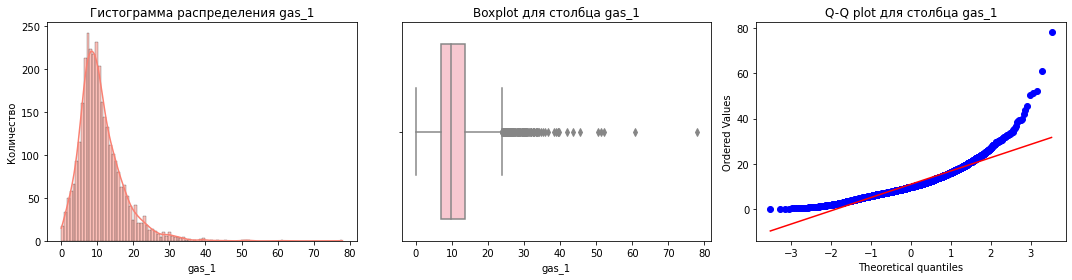

In [156]:
short_dif_graphics(gas_new, 'gas_new')

Для 75% всех партий объем подаваемого для продувки газа не превышает 13,8 куб.м., при этом чаще всего используется около 10 куб. м. Длинный xвост на гистограмме справа говорит нам о наличии выбросов, что подтверждается графиком боксплот. Сложно судить об аномальности таких значений. Распределение данных о газе ненормальное, изучим выбросы дополнительно после объединения таблиц. 

### Данные о проволочных материалах

Рассмотрим сведения об объеме использованных проволочных материалов. Структура этого датасета похожа на bulk_new. Заполним пропуски 0 и добавим столбцы с общим объемом добавок для каждой партии и количеством использованных материалов.

In [157]:
wire_new.fillna(0, inplace=True)

In [158]:
wire_new['wire_total'] = wire_new.drop(columns='key').sum(axis=1)

In [159]:
wire_new['wire_amount'] = wire_new.drop(columns=['key', 'wire_total']).apply(lambda x: (x != 0).sum(), axis=1)

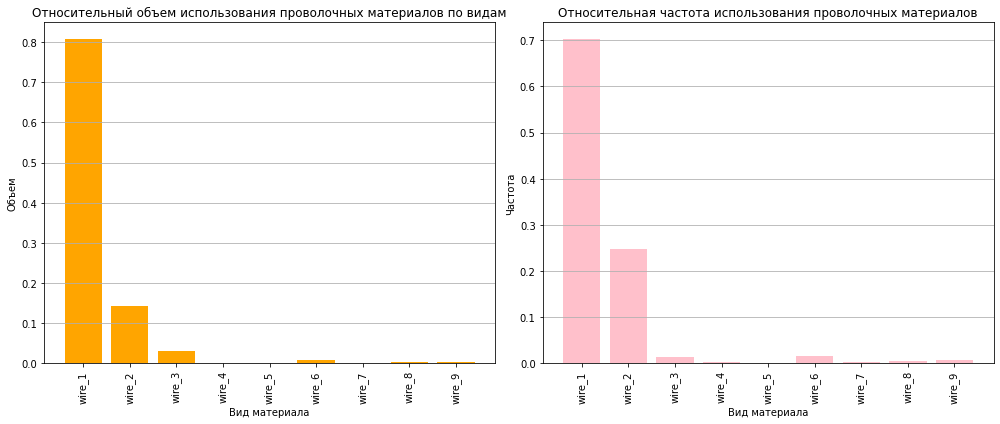

In [160]:
wire_freq = wire_new.iloc[:, 1:-2].astype(bool).sum(axis=0)
wire_sums = wire_new.iloc[:, 1:-2].sum()
wire_freq_relat = wire_freq/wire_freq.sum()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar((wire_sums/wire_sums.sum()).index, (wire_sums/wire_sums.sum()).values, color='orange')
axes[0].set_title('Относительный объем использования проволочных материалов по видам')
axes[0].set_xlabel('Вид материала')
axes[0].set_ylabel('Объем')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, axis='y')

axes[1].bar((wire_freq/wire_freq.sum()).index, wire_freq_relat.values, color='pink')
axes[1].set_title('Относительная частота использования проволочных материалов')
axes[1].set_xlabel('Вид материала')
axes[1].set_ylabel('Частота')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Из девяти видов проволочных материалов только 2 используются достаточно часто: wire_1 и wire_2. Для наиболее редких видов, частота появления которых менее 2% от всех добавок, создадим отдельную категорию.

In [161]:
rarest_wires = wire_freq_relat[wire_freq_relat < 0.020].index

In [162]:
rarest_wires

Index(['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], dtype='object')

In [163]:
wire_new['wire_rare'] = wire_new[rarest_wires].sum(axis=1)

count        mean        std     min       25%         50%  \
wire_1       3081.0  100.044411  42.841120  0.0000  70.28112  100.114563   
wire_2       3081.0   17.712733  33.517734  0.0000   0.00000    0.000000   
wire_3       3081.0    3.874524  30.310417  0.0000   0.00000    0.000000   
wire_4       3081.0    0.261019   4.293865  0.0000   0.00000    0.000000   
wire_5       3081.0    0.004911   0.272615  0.0000   0.00000    0.000000   
wire_6       3081.0    1.137695   8.958111  0.0000   0.00000    0.000000   
wire_7       3081.0    0.035842   0.774190  0.0000   0.00000    0.000000   
wire_8       3081.0    0.330697   4.392677  0.0000   0.00000    0.000000   
wire_9       3081.0    0.321492   3.806904  0.0000   0.00000    0.000000   
wire_total   3081.0  123.723326  66.082966  1.9188  86.11200  114.179523   
wire_amount  3081.0    1.409932   0.578078  1.0000   1.00000    1.000000   
wire_rare    3081.0    5.966181  34.846050  0.0000   0.00000    0.000000   

                    75%         max  
wire_1       125.798405  330.314424  
wire_2        23.162880  282.780152  
wire_3         0.000000  385.008668  
wire_4         0.000000  113.231044  
wire_5         0.000000   15.132000  
wire_6         0.000000  180.454575  
wire_7         0.000000   32.847674  
wire_8         0.000000  102.762401  
wire_9         0.000000   90.053604  
wire_total   150.181198  663.851766  
wire_amount    2.000000    5.000000  
wire_rare      0.000000  385.008668

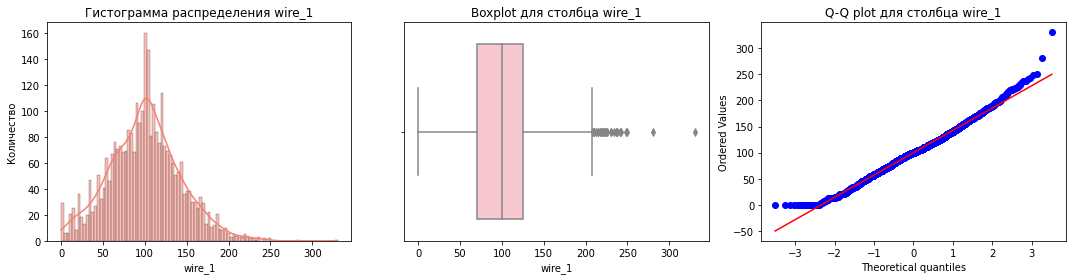

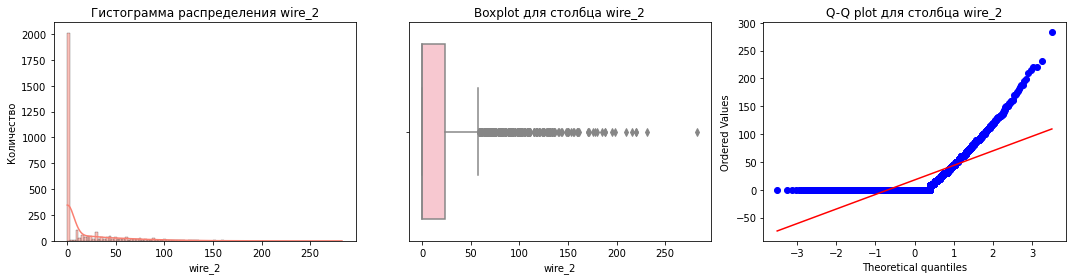

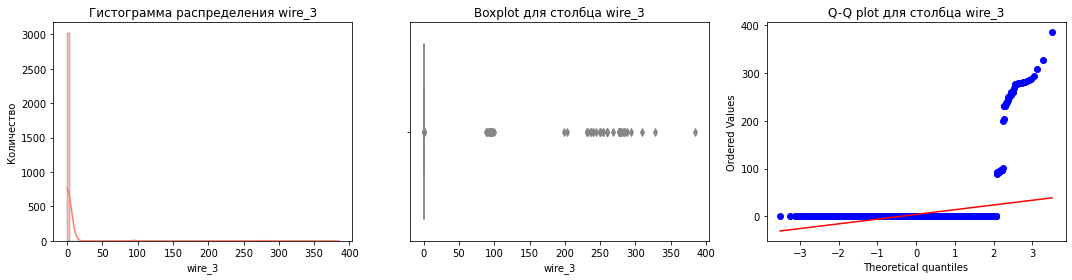

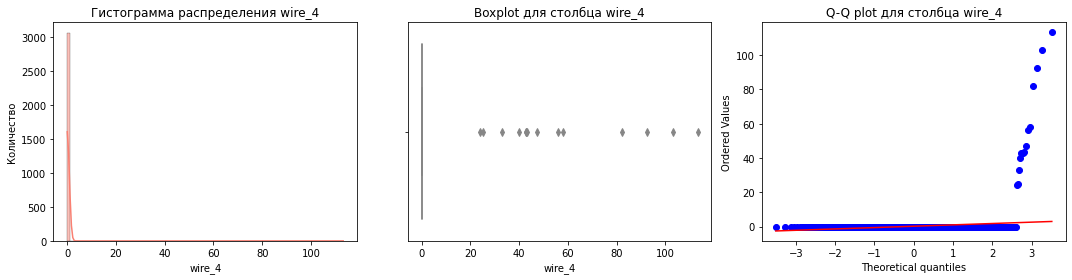

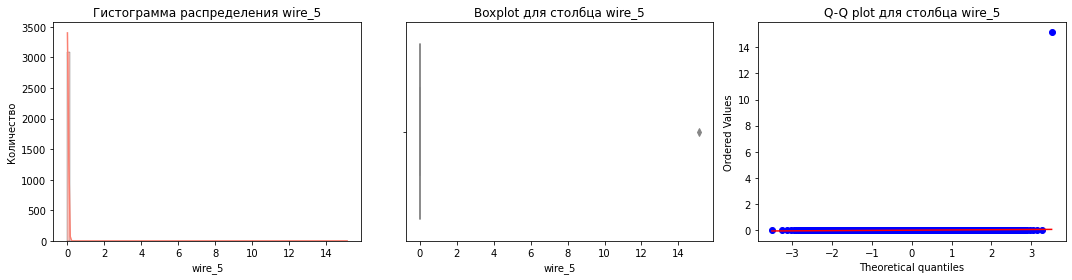

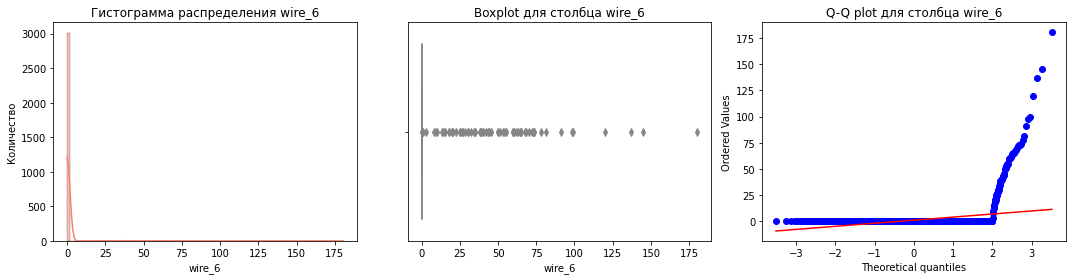

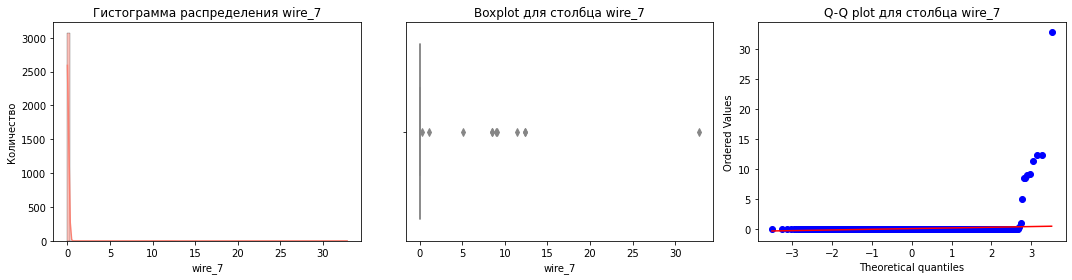

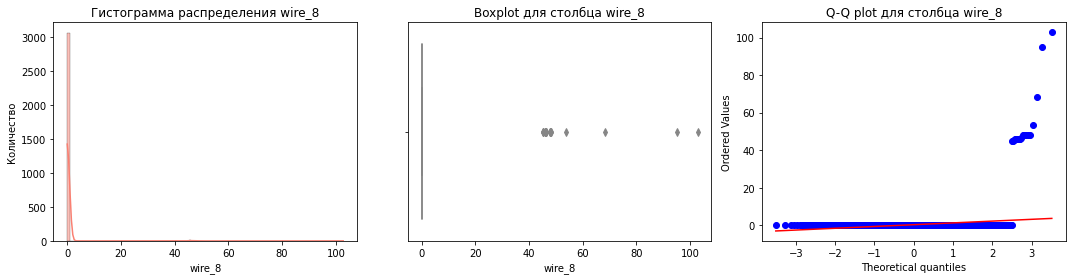

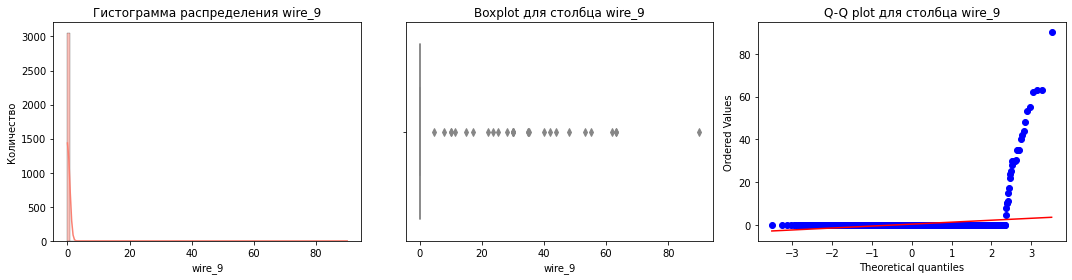

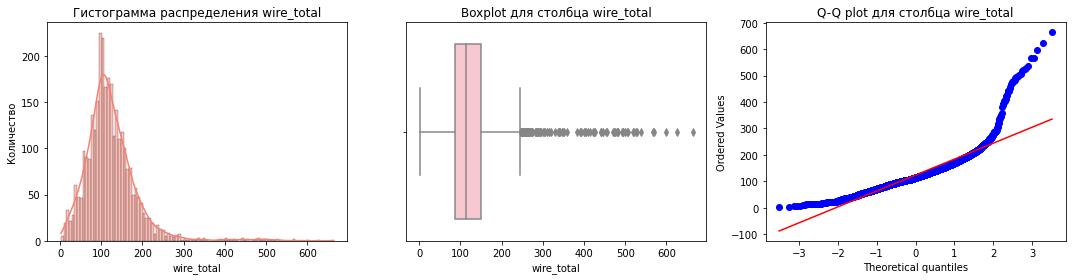

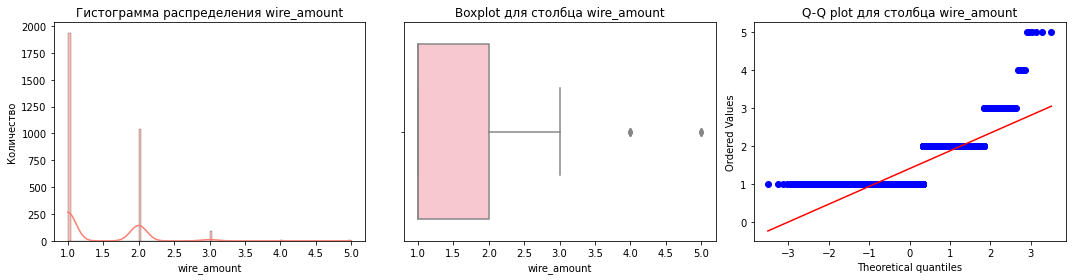

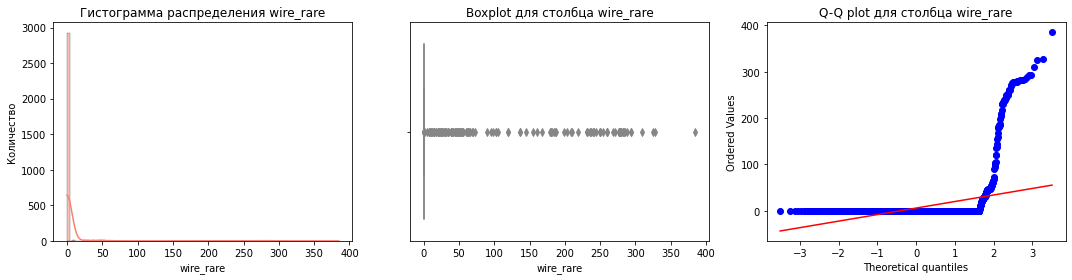

In [164]:
short_dif_graphics(wire_new, 'wire_new')

Для 50% всех партий характерно использование только одного проволочного материала, в редких случаях используются больше трех. 

In [165]:
not_rarest_wires = wire_new.columns.difference(rarest_wires).tolist()

In [166]:
not_rarest_wires

['key', 'wire_1', 'wire_2', 'wire_amount', 'wire_rare', 'wire_total']

Как и для сыпучих материалов, использование времени подачи проволочных материалов для построения модели нецелесообразно. Поэтому перейдем к изучению целевого признака - температуры.

### Результаты измерения температуры

In [167]:
temp_new['temperature'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

Температура стали на на разных циклах обработки принимает значения от 1191 до 1705 °C. Из открытых источников мы знаем, что температура плавления стали находится в диапазоне 1450—1520 °C. Если опустить температуру ниже этой отметки, то химические реакции, необходимые для легирования или удаления примесей, произойдут медленнее или вовсе остановятся, что может отрицательно сказаться на качестве стали. Поверхность стали может окислиться, а также она может приобрести нежелательную микроструктуру, что ухудшит механические свойства стали. Поэтому надо обратить отдельное внимание на минимальные значения температуры.

In [168]:
outlaw_keys = temp_new.query('temperature < 1450')['key']
temp_new[temp_new['key'].isin(outlaw_keys)]

key        measure_time  temperature
4883    867 2019-06-06 08:03:39       1191.0
4884    867 2019-06-06 08:18:52       1575.0
4885    867 2019-06-06 08:22:38       1576.0
4886    867 2019-06-06 08:25:11       1571.0
4887    867 2019-06-06 08:29:49       1600.0
4888    867 2019-06-06 08:36:49       1522.0
4889    867 2019-06-06 08:43:02       1521.0
4890    867 2019-06-06 08:48:23       1599.0
6784   1214 2019-06-18 08:01:03       1208.0
6785   1214 2019-06-18 08:17:56       1608.0
6786   1214 2019-06-18 08:31:10       1608.0
6787   1214 2019-06-18 08:43:56       1591.0
9050   1619 2019-07-03 02:34:41       1218.0
9051   1619 2019-07-03 02:39:29       1623.0
9052   1619 2019-07-03 02:43:59       1590.0
11495  2052 2019-07-25 08:49:15       1227.0
11496  2052 2019-07-25 08:54:39       1592.0
11497  2052 2019-07-25 09:03:59       1590.0
11498  2052 2019-07-25 09:07:19       1591.0
11499  2052 2019-07-25 09:20:11       1515.0
11500  2052 2019-07-25 09:27:03       1592.0
14283  2561 2019-08-12 18:49:29       1204.0
14284  2561 2019-08-12 18:59:23          NaN
14285  2561 2019-08-12 19:06:26          NaN
14286  2561 2019-08-12 19:11:13          NaN
14287  2561 2019-08-12 19:17:08          NaN
14288  2561 2019-08-12 19:21:45          NaN

Датасет содержит пять партий, в которых первое измерение температуры является критически низким для стали, при такой температуре партии могут стать бракованными. Из-за нарушения технологических процессов, конечный результат может быть непредсказуемым, поэтому лучше исключить партии с выбросами из исследования.

In [169]:
temp_new = temp_new[~temp_new['key'].isin(outlaw_keys)].copy()

Добавим столбец с разницей между последовательными измерениями температуры для каждой партии.

In [170]:
temp_new['temp_change'] = temp_new.groupby('key')['temperature'].diff()

count         mean        std     min     25%     50%     75%  \
temperature  14643.0  1590.865055  19.122102  1519.0  1580.0  1590.0  1599.0   
temp_change  11432.0     1.367565  11.846958   -96.0    -5.0     1.0     8.0   

                max  
temperature  1705.0  
temp_change    81.0

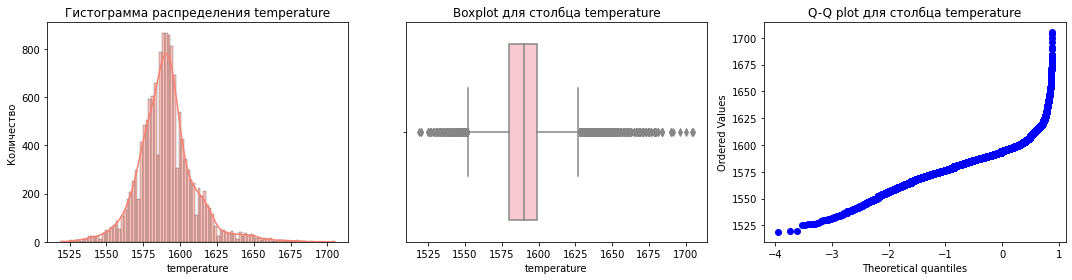

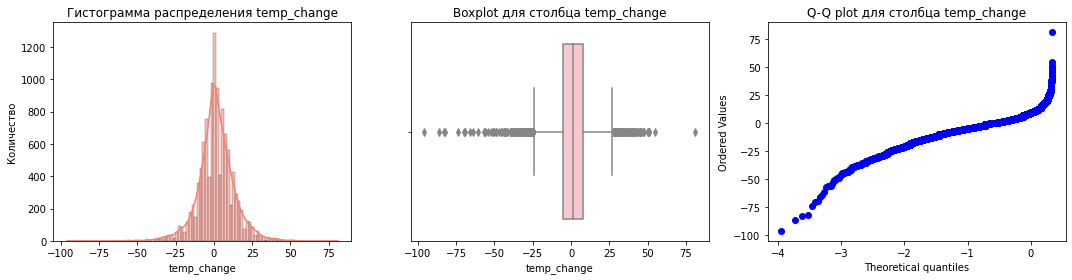

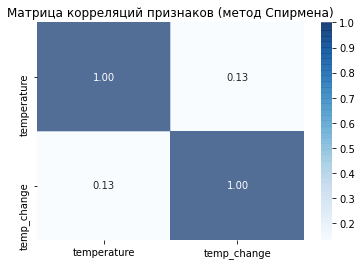

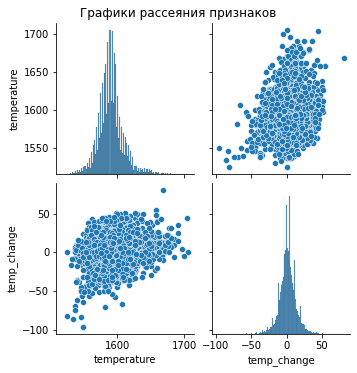

In [171]:
dif_graphics(temp_new[['key','temperature', 'temp_change']], 'temp_new')

Средняя температура совпадает с медианой - около 1590 °C, распределение данных ненормальное, на графике есть длинных хвост справа: значения выше 1650 градусов достаточно редки. Чаще всего значения температуры внутри партии отличаются от предыдущего на +/- 25 °C, при этом самые распространенные величины этой разницы сгруппированы около нуля, что указывает на стабильность процесса с небольшими колебаниями температуры, но есть и строки со значительными измениями, например, в одном случае наблюдается нагрев на 81 °C. Изучим партии с отклонением больше +55 °C.

In [172]:
temp_new[temp_new['key'].isin(temp_new.query('temp_change >= 55')['key'])]

key        measure_time  temperature  temp_change
5246   929 2019-06-08 13:28:38       1603.0          NaN
5247   929 2019-06-08 13:33:13       1658.0         55.0
5248   929 2019-06-08 13:42:07       1658.0          0.0
5249   929 2019-06-08 13:47:00       1670.0         12.0
5250   929 2019-06-08 13:50:19       1679.0          9.0
8540  1525 2019-06-29 20:15:31       1587.0          NaN
8541  1525 2019-06-29 20:21:08       1668.0         81.0
8542  1525 2019-06-29 20:25:09       1637.0        -31.0
8543  1525 2019-06-29 20:34:49       1662.0         25.0
8544  1525 2019-06-29 20:40:40       1674.0         12.0
8545  1525 2019-06-29 20:44:50       1681.0          7.0

Температура резко возросла после первого нагрева, затем в одном случае резко упала на 31 °C, возможно нагрев на 81 °C произошел по ошибке, последующие изменения колебались в пределах 7-25 °C. Видимо, сталь имела слишком низкую температуру для дальнейшей обработки, когда была залита в ковш. 

Рассмотрим характер резких снижений температуры стали, по модулю потери тепла значительно больше.

In [173]:
low_temp = temp_new[temp_new['key'].isin(temp_new.query('temp_change < -55')['key'])]

In [174]:
temperature_diff = low_temp.groupby('key').agg(
    max_delta=('temp_change', 'min'),
    first_temp=('temperature', 'first'),
    last_temp=('temperature', 'last'),
    count=('temperature', 'count')
)
temperature_diff['temp_diff'] = temperature_diff['last_temp'] - temperature_diff['first_temp']

In [175]:
temperature_diff

max_delta  first_temp  last_temp  count  temp_diff
key                                                     
46        -69.0      1607.0     1612.0     14        5.0
78        -56.0      1604.0     1583.0      6      -21.0
614       -56.0      1651.0     1595.0      2      -56.0
641       -74.0      1617.0     1580.0      7      -37.0
661       -66.0      1673.0     1607.0      2      -66.0
687       -83.0      1629.0     1587.0      8      -42.0
801       -96.0      1638.0     1582.0      8      -56.0
838       -56.0      1615.0     1600.0      5      -15.0
1032      -61.0      1601.0     1577.0      6      -24.0
1689      -82.0      1583.0     1606.0     16       23.0
1881      -64.0      1584.0     1583.0      9       -1.0
1914      -57.0      1654.0     1597.0      2      -57.0
1988      -70.0      1652.0     1582.0      2      -70.0
2108      -86.0      1639.0     1541.0     17      -98.0

In [176]:
temp_new.query('key==801')

key        measure_time  temperature  temp_change
4476  801 2019-06-03 14:47:07       1638.0          NaN
4477  801 2019-06-03 14:50:39       1636.0         -2.0
4478  801 2019-06-03 14:58:02       1646.0         10.0
4479  801 2019-06-03 17:56:20       1550.0        -96.0
4480  801 2019-06-03 18:00:30       1550.0          0.0
4481  801 2019-06-03 18:07:43       1579.0         29.0
4482  801 2019-06-03 18:18:45       1600.0         21.0
4483  801 2019-06-03 18:22:02       1582.0        -18.0

Самая высокая разница в температурах, возможно, связана с тем, что ковш был оставлен почти на 3 часа (при нормальной разнице между измерениями температуры до 10 минут) и успел остыть, но не достиг критического значения минимальной температуры стали. В остальных случаях сильное охлаждение также может быть связано с исходной температурой подачи стали в ковш или спецификой процессов: например, интенсивным перемешиванием или температурой добавляемых материалов (если они были охлаждены, то часть тепла могла потратиться на теплопередачу).



Нам предстоит построить модель, которая будет прогнозировать последнее значение измерения температуры перед подачей сплава в машину непрерывной разливки. Поэтому необходимо сопоставить время выполнения всех операций и оставить только те записи об измерении температуры, которые являются последними во всем цикле обработки расплавленной стали.

Как мы помним, сведения о замере температуры содержат пропуски, это значит, что нам придется удалить партии в которых содержатся пропуски в последнем измерении. Cначала изучим характер распределения пропусков в температуре.

In [177]:
miss_temp_info = (temp_new.groupby('key')).agg(
    measure_count=('temperature', 'size'),
    missing_measure=('temperature', lambda x: x.isna().sum())
).reset_index()

In [178]:
missed_temp = miss_temp_info[(miss_temp_info['measure_count'] - miss_temp_info['missing_measure']) < miss_temp_info['measure_count']]
missed_temp = missed_temp.sort_values(by='key')
missed_temp

key  measure_count  missing_measure
2473  2500              5              4.0
2474  2501              7              6.0
2475  2502              5              4.0
2476  2503              5              4.0
2477  2504              6              5.0
...    ...            ...              ...
3206  3237              6              5.0
3207  3238              4              3.0
3208  3239              9              8.0
3209  3240              6              5.0
3210  3241              6              5.0

[738 rows x 3 columns]

С партии 2500 начинаются пропуски в температуре и наблюдаются в последующих партиях.

In [179]:
bad_keys_temp = missed_temp['key']
temp_new[~temp_new['key'].isin(bad_keys_temp)]['key'].max()

2499

In [180]:
missed_temp['ok_count'] = missed_temp['measure_count'] - missed_temp['missing_measure']
(missed_temp['ok_count'] == 1).all()

True

In [181]:
temp_new.query('key==2500')['measure_time'].head(1)

13926   2019-08-10 14:04:39
Name: measure_time, dtype: datetime64[ns]

После 14:04 10.08.2019 все партии начинают содержать пропуски в показаниях температуры. При этом одна запись для каждой партии всегда заполнена корректно.

In [182]:
temp_new.tail(21)

key        measure_time  temperature  temp_change
18071  3239 2019-09-06 14:16:50       1598.0          NaN
18072  3239 2019-09-06 14:22:49          NaN          NaN
18073  3239 2019-09-06 14:28:54          NaN          NaN
18074  3239 2019-09-06 14:33:34          NaN          NaN
18075  3239 2019-09-06 14:42:48          NaN          NaN
18076  3239 2019-09-06 14:56:58          NaN          NaN
18077  3239 2019-09-06 14:59:25          NaN          NaN
18078  3239 2019-09-06 15:03:35          NaN          NaN
18079  3239 2019-09-06 15:09:55          NaN          NaN
18080  3240 2019-09-06 15:25:21       1617.0          NaN
18081  3240 2019-09-06 15:30:52          NaN          NaN
18082  3240 2019-09-06 15:58:35          NaN          NaN
18083  3240 2019-09-06 16:02:31          NaN          NaN
18084  3240 2019-09-06 16:21:44          NaN          NaN
18085  3240 2019-09-06 16:35:26          NaN          NaN
18086  3241 2019-09-06 16:48:55       1586.0          NaN
18087  3241 2019-09-06 16:55:01          NaN          NaN
18088  3241 2019-09-06 17:06:38          NaN          NaN
18089  3241 2019-09-06 17:21:48          NaN          NaN
18090  3241 2019-09-06 17:24:44          NaN          NaN
18091  3241 2019-09-06 17:30:05          NaN          NaN

Судя по наблюдениям самое первое измерение всегда зафиксировано. Проверим, действительно ли это так для всех партий.

In [183]:
temp_new.sort_values('measure_time').groupby('key').head(1).isna().sum()

key                0
measure_time       0
temperature        0
temp_change     3211
dtype: int64

Кажется, на производстве есть проблема со снятием показаний температуры сплава - фиксируются только результаты самого первого измерения. Проверим, легировалась ли сталь для этих партий, возможно, изменение состава не требовалось после первичного анализа.

In [184]:
wire_new[wire_new['key'].isin(bad_keys_temp)].shape

(707, 13)

In [185]:
bulk_new[bulk_new['key'].isin(bad_keys_temp)].shape

(720, 19)

In [186]:
arc_new[arc_new['key'].isin(bad_keys_temp)].shape

(3422, 9)

Партии с пропусками в измерениях температуры проходили этапы обработки, соответственно пропущенных значений не должно было быть, можно удалить их.

In [187]:
temp_new = temp_new[~temp_new['key'].isin(bad_keys_temp)].copy()

In [188]:
temp_new['key'].nunique()

2473

In [189]:
temp_new.isna().sum()

key                0
measure_time       0
temperature        0
temp_change     2473
dtype: int64

Всего в датасете temp_new на начало работы была информация о 3216 партиях, после удаления пропусков осталось 2473 партии.  Теперь проверим логическое соответствие завершения всех операций обработки времени последнего измерения температуры.

In [190]:
last_time_temp = temp_new.sort_values('measure_time').groupby('key').tail(1)
last_time_heat = arc_new.sort_values('stop_heating').groupby('key').tail(1)
bulk_time_new['last_time'] = bulk_time_new.iloc[:, 1:].max(axis=1)
wire_time_new['last_time'] = wire_time_new.iloc[:, 1:].max(axis=1)

In [191]:
error_keys = []
extra_keys = []

for key, measure_time in last_time_temp[['key', 'measure_time']].values:
    last_times = []

    bulk_last_time = bulk_time_new.loc[bulk_time_new['key'] == key, 'last_time']
    wire_last_time = wire_time_new.loc[wire_time_new['key'] == key, 'last_time']
    heat_last_time = last_time_heat.loc[last_time_heat['key'] == key, 'stop_heating']

    if not bulk_last_time.empty:
        last_times.append(bulk_last_time.values[0])
    if not wire_last_time.empty:
        last_times.append(wire_last_time.values[0])
    if not heat_last_time.empty:
        last_times.append(heat_last_time.values[0])

    if last_times and measure_time < max(last_times):
        error_keys.append(key)
    

print('Партии с непоследовательной фиксацией времени')
print(error_keys)

Партии с непоследовательной фиксацией времени
[279]


In [192]:
temp_new.query('key in @error_keys')

key        measure_time  temperature  temp_change
1549  279 2019-05-14 10:13:01       1603.0          NaN

In [193]:
wire_time_new.query('key in @error_keys')

key              wire_1 wire_2 wire_3 wire_4 wire_5 wire_6 wire_7 wire_8  \
256  279 2019-05-14 10:13:37    NaT    NaT    NaT    NaT    NaT    NaT    NaT   

    wire_9           last_time  
256    NaT 2019-05-14 10:13:37

In [194]:
bulk_time_new.query('key in @error_keys')

key bulk_1 bulk_2 bulk_3 bulk_4 bulk_5              bulk_6 bulk_7 bulk_8  \
261  279    NaT    NaT    NaT    NaT    NaT 2019-05-14 10:13:37    NaT    NaT   

    bulk_9 bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15           last_time  
261    NaT     NaT     NaT     NaT     NaT     NaT     NaT 2019-05-14 10:13:37

In [195]:
temp_new = temp_new[~temp_new['key'].isin(error_keys)].copy()

Для партии 279 логическое условие не выполнилось: нет измерения температуры после добавления легирующих материалов. Но помимо этого возникает вопрос: может ли для партии существовать только одно измерение температуры? Как мы установили ранее, во всех партиях проводилась корректировка химического состава. При этом процессе замер температуры должен происходить как минимум дважды - перед первым вводом добавки и после перемешивания, если в наших данных есть только однократное измерение температуры, эти данные нельзя включать в построение модели. Количество нагреваний должно быть всегда меньше на 1, чем измерений температуры.
Создадим сводную таблицу по партиям, куда включим время первого и последнего измерения, значения температуры в эти моменты, количество измерений, а также среднюю температуру для каждой партии.

In [196]:
last_measure = temp_new.sort_values('measure_time').groupby('key').tail(1)
first_measure = temp_new.sort_values('measure_time').groupby('key').head(1)

measure_stats = temp_new.groupby('key').agg(
    meas_count=('key', 'size'),
    mean_temp=('temperature', 'mean'),
    mean_temp_change=('temp_change', lambda x: x.abs().mean())
).reset_index()

temp_new_pivot = last_measure.merge(first_measure, on='key', suffixes=('_end', '_start'))
temp_new_pivot = temp_new_pivot.merge(measure_stats, on='key')

columns_to_drop = ['temp_change_end', 'abs_temp_change_start', 'temp_change_start', 'abs_temp_change_end']
temp_new_pivot.drop(columns=columns_to_drop, inplace=True, errors='ignore')

temp_new_pivot.head()

key    measure_time_end  temperature_end  measure_time_start  \
0    1 2019-05-03 11:30:38           1613.0 2019-05-03 11:02:04   
1    2 2019-05-03 11:55:09           1602.0 2019-05-03 11:34:04   
2    3 2019-05-03 12:35:57           1599.0 2019-05-03 12:06:44   
3    4 2019-05-03 12:59:47           1625.0 2019-05-03 12:39:27   
4    5 2019-05-03 13:36:39           1602.0 2019-05-03 13:11:03   

   temperature_start  meas_count    mean_temp  mean_temp_change  
0             1571.0           6  1602.166667             15.20  
1             1581.0           5  1590.600000              8.25  
2             1596.0           6  1598.166667              1.00  
3             1601.0           5  1616.800000              9.00  
4             1576.0           5  1589.000000              9.50

In [198]:
temp_new_pivot.query('meas_count == 1')

key    measure_time_end  temperature_end  measure_time_start  \
191  195 2019-05-11 00:01:36           1583.0 2019-05-11 00:01:36   

     temperature_start  meas_count  mean_temp  mean_temp_change  
191             1583.0           1     1583.0               NaN

In [199]:
temp_new_pivot = temp_new_pivot.query('meas_count > 1').copy()
temp_new = temp_new.query('key != 195').copy()

Добавим длительность в секундах между последним и первым измерением.

In [200]:
temp_new_pivot['measure_period'] = (temp_new_pivot['measure_time_end']-temp_new_pivot['measure_time_start']).dt.total_seconds()

count         mean          std     min          25%  \
temperature_end    2471.0  1595.339943    16.035215  1541.0  1587.000000   
temperature_start  2471.0  1589.012950    25.004369  1519.0  1572.000000   
meas_count         2471.0     5.626467     1.609465     2.0     5.000000   
mean_temp          2471.0  1591.614614    16.337884  1547.0  1581.500000   
mean_temp_change   2471.0     8.785803     5.220397     0.0     5.333333   
measure_period     2471.0  2281.317685  1374.343709   339.0  1544.500000   

                           50%     75%      max  
temperature_end    1593.000000  1599.0   1700.0  
temperature_start  1588.000000  1605.0   1679.0  
meas_count            5.000000     7.0     17.0  
mean_temp          1589.833333  1599.0   1681.8  
mean_temp_change      8.000000    11.0     70.0  
measure_period     2007.000000  2739.5  23674.0

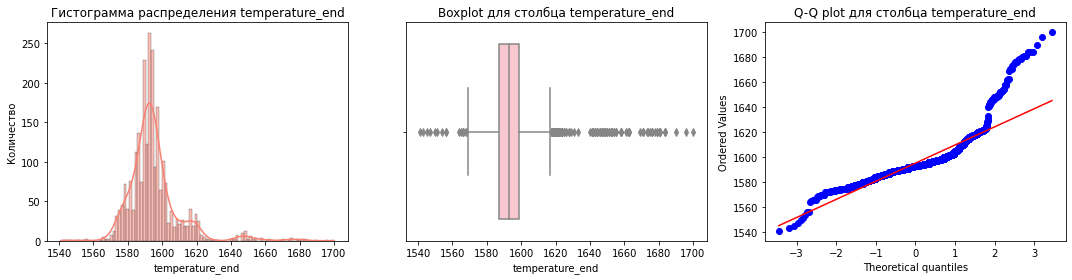

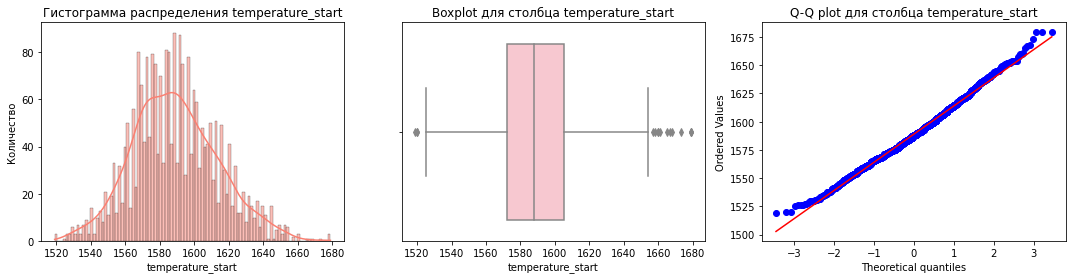

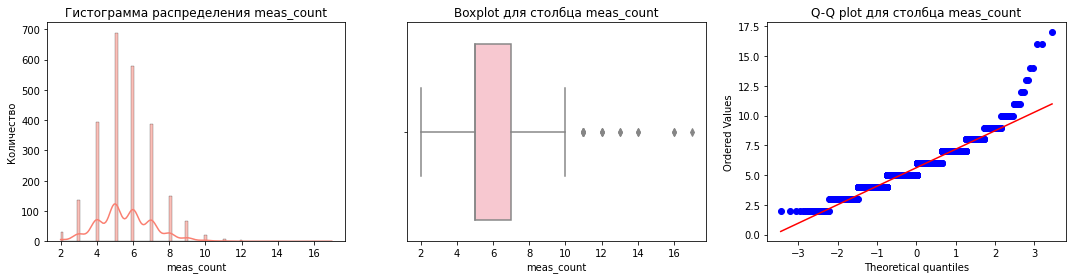

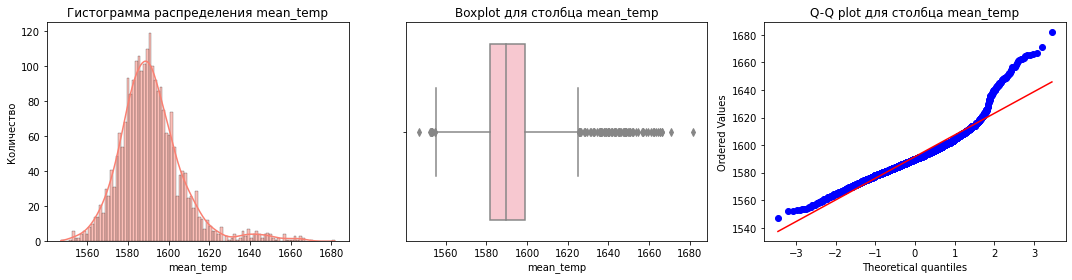

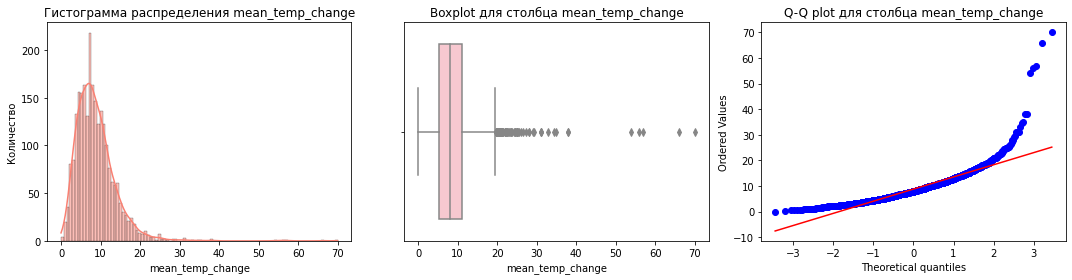

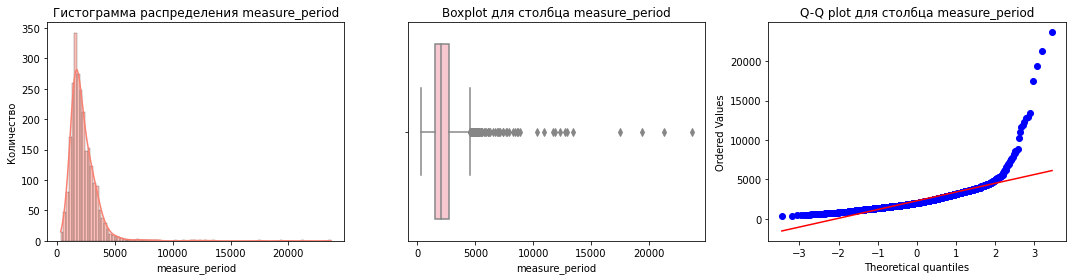

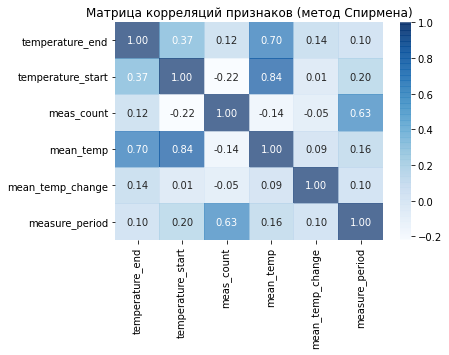

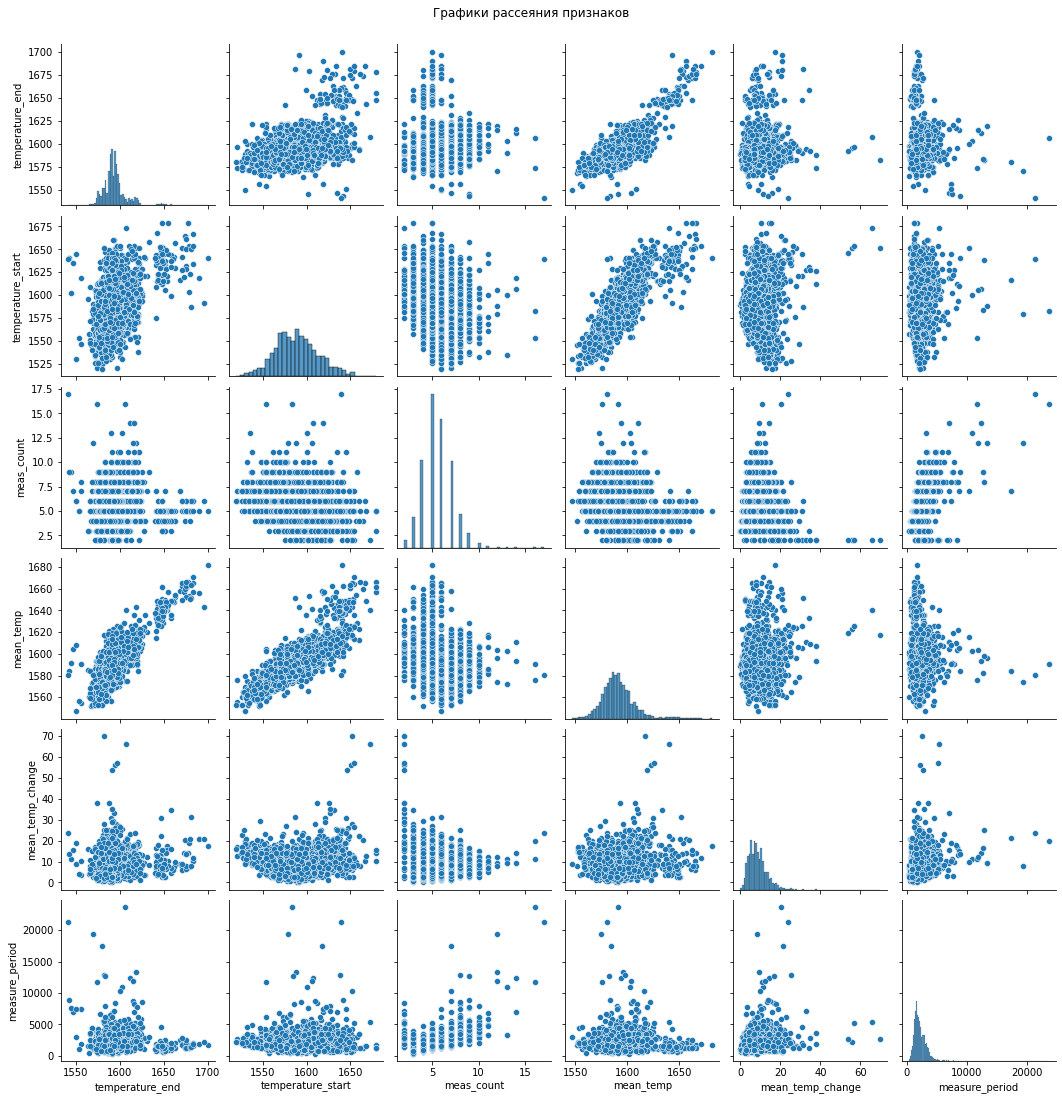

In [201]:
dif_graphics(temp_new_pivot, 'temp_new_pivot')

Целевой признак - конечная температура - принимает значения из диапазона 1541-1700 градусов, но большинство значений находятся в пределе 1580-1610 градусов. График распределения смещен влево, среднее значение 1595 градусов, распределение ненормальное, высокие температуры встречаются редко. График распределения начальной температуры стремится к нормальному, диапазон значений сдвинут влево относительно конечной температуры. Средняя температура сильно коррелирует со стартовой температурой и умеренно - с конечной. Максимальное количество измерений - 17, но в 75% случаев не превышает 7, чаще всего записи о партиях содержат 5-6 измерений температуры. В основном последовательные измерения температуры отличаются друг от друга на величину до 15 градусов (по модулю), но имеется небольшое количество экстремальных значений. Продолжительность обработки стали в 75% случаев не превышает 47 минут (2739 сек), минимальное время - 5 минут 39 секунд, а максимальное - 6 часов 34 минуты 34 секунды.

**ВЫВОД:**

Для удобства анализа и дальнейшей работы с данными мы изменили названия столбцов, переведя их в латиницу и нижний регистр с использованием нижнего подчеркивания.

**Анализ датасета arc_new:**  
- **Аномальные значения:** Обнаружено аномально низкое значение реактивной мощности, что значительно отличается от нормальных значений в датасете. Ошибка могла возникнуть на этапе сбора данных. Для устранения аномалии использовали модель линейной регрессии, что позволило корректно заменить ошибочное значение.
- **Корреляция мощностей:** Между активной и реактивной мощностями наблюдается сильная линейная зависимость. Для уменьшения мультиколлинеарности были введены новые признаки: полная мощность, коэффициент мощности и потребленная активная энергия.

**Анализ датасета bulk_new:**  
- **Пропуски в данных:** Пропущенные значения заменены на 0, так как они означают неиспользование материала. Анализ показал, что наиболее часто используются материалы Bulk 14, Bulk 12 и Bulk 15.
- **Новые признаки:** Созданы новые признаки – общий объем добавок и их количество. Объем и частота использования материалов показывают некоторую корреляцию: Bulk 12, Bulk 14 и Bulk 15 составляют 80% всего объема сыпучих материалов. Для редко используемых материалов (менее 2% случаев) создана отдельная категория.
- **Выбросы:** Обнаружены крупные выбросы в объемах и количестве использованных материалов, но их удаление отложено до дальнейшего анализа.

**Анализ датасета wire_new:**  
- **Пропуски в данных:** Пропуски заполнены значением 0. Из девяти видов проволочных материалов чаще всего используются wire_1 и wire_2.
- **Новые признаки:** Созданы признаки общего объема добавок и их количества. Для редко используемых материалов (менее 2% случаев) создана отдельная категория.

**Анализ целевого признака – температуры:**  
- **Аномальные партии:** Обнаружены пять партий с критически низкой начальной температурой. Эти партии могут быть бракованными и лучше исключить их из анализа.
- **Температурные колебания:** Различия между последовательными измерениями температуры чаще всего лежат в диапазоне +/- 25 °C. 
- **Временные параметры:** Сопоставлены временные последовательности всех операций. Удалены партии с пропусками в последнем измерении температуры.
- **Сводная таблица:** Создана сводная таблица по партиям с включением времени первого и последнего измерения, значений температуры, количества измерений, средней температуры и длительности обработки.
- **Целевой признак:** Конечная температура варьируется от 1541 до 1700 градусов, с большинством значений в пределах 1580-1610 градусов.


## Объединение данных <a id="шаг_3"></a>

Данные готовы, будем последовательно присоединять датасеты к temp_new_pivot, так как он содержит целевой признак, нам важно сохранить партии, который он содержит.

In [202]:
final = temp_new_pivot.merge(arc_new_pivot, on='key', how='inner')

In [203]:
final = final.merge(bulk_new[not_rarest_bulks], on='key', how='inner')

In [204]:
final = final.merge(wire_new[not_rarest_wires], on='key', how='inner')

In [205]:
final = final.merge(gas_new, on='key', how='inner')

In [206]:
final = final.drop(columns=['measure_time_end', 'measure_time_start'])

In [207]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2325 non-null   int64  
 1   temperature_end      2325 non-null   float64
 2   temperature_start    2325 non-null   float64
 3   meas_count           2325 non-null   int64  
 4   mean_temp            2325 non-null   float64
 5   mean_temp_change     2325 non-null   float64
 6   measure_period       2325 non-null   float64
 7   mean_active_energy   2325 non-null   float64
 8   mean_apparent_power  2325 non-null   float64
 9   mean_heating_period  2325 non-null   float64
 10  mean_power_coef      2325 non-null   float64
 11  heating_count        2325 non-null   int64  
 12  bulk_1               2325 non-null   float64
 13  bulk_12              2325 non-null   float64
 14  bulk_14              2325 non-null   float64
 15  bulk_15              2325 non-null   f

Конечный набор данных содержит информацию о 2325 партиях. 

count         mean          std          min  \
temperature_end      2325.0  1593.366022    11.209581  1541.000000   
temperature_start    2325.0  1587.365161    23.623144  1519.000000   
meas_count           2325.0     5.696344     1.605930     2.000000   
mean_temp            2325.0  1589.797806    12.945590  1547.000000   
mean_temp_change     2325.0     8.698047     4.990958     0.000000   
measure_period       2325.0  2323.419785  1385.569302   339.000000   
mean_active_energy   2325.0     0.031839     0.010620     0.005763   
mean_apparent_power  2325.0     0.825649     0.160377     0.331897   
mean_heating_period  2325.0   172.090653    43.751112    57.000000   
mean_power_coef      2325.0     1.243023     0.021981     1.166803   
heating_count        2325.0     4.696344     1.605930     1.000000   
bulk_1               2325.0     3.433548    12.421994     0.000000   
bulk_12              2325.0   208.507957   157.137873     0.000000   
bulk_14              2325.0   153.971613    81.398153     0.000000   
bulk_15              2325.0   120.026667    84.674380     0.000000   
bulk_3               2325.0    47.296774    75.228262     0.000000   
bulk_4               2325.0    37.331613    58.670377     0.000000   
bulk_6               2325.0    22.468817    55.831097     0.000000   
bulk_rare            2325.0    16.927742    65.843154     0.000000   
bulks_amount         2325.0     3.593978     1.224168     1.000000   
bulks_total          2325.0   609.964731   287.569669    19.000000   
wire_1               2325.0   102.412198    43.535263     0.000000   
wire_2               2325.0    17.605637    33.642919     0.000000   
wire_amount          2325.0     1.396989     0.564505     1.000000   
wire_rare            2325.0     5.163939    32.876993     0.000000   
wire_total           2325.0   125.181774    63.685486     1.918800   
gas_1                2325.0    11.378942     6.395632     0.008399   

                             25%          50%          75%           max  
temperature_end      1587.000000  1593.000000  1598.000000   1653.000000  
temperature_start    1571.000000  1587.000000  1603.000000   1660.000000  
meas_count              5.000000     6.000000     7.000000     17.000000  
mean_temp            1581.250000  1589.500000  1598.000000   1646.000000  
mean_temp_change        5.333333     8.000000    11.000000     70.000000  
measure_period       1581.000000  2046.000000  2793.000000  23674.000000  
mean_active_energy      0.024246     0.030462     0.038379      0.098611  
mean_apparent_power     0.714331     0.818378     0.921276      1.572238  
mean_heating_period   141.000000   169.500000   198.750000    378.000000  
mean_power_coef         1.228022     1.241904     1.256567      1.351762  
heating_count           4.000000     5.000000     6.000000     16.000000  
bulk_1                  0.000000     0.000000     0.000000    185.000000  
bulk_12               105.000000   206.000000   283.000000   1849.000000  
bulk_14               105.000000   149.000000   204.000000    636.000000  
bulk_15                 0.000000   107.000000   204.000000    405.000000  
bulk_3                  0.000000     0.000000    80.000000    454.000000  
bulk_4                  0.000000     0.000000    77.000000    281.000000  
bulk_6                  0.000000     0.000000     0.000000    503.000000  
bulk_rare               0.000000     0.000000     0.000000   1156.000000  
bulks_amount            3.000000     4.000000     4.000000      7.000000  
bulks_total           440.000000   609.000000   796.000000   3235.000000  
wire_1                 73.207679   101.087998   128.069763    330.314424  
wire_2                  0.000000     0.000000    23.102560    282.780152  
wire_amount             1.000000     1.000000     2.000000      5.000000  
wire_rare               0.000000     0.000000     0.000000    385.008668  
wire_total             89.013596   116.101440   151.550872    568.777664  
gas_1                   7.282948    

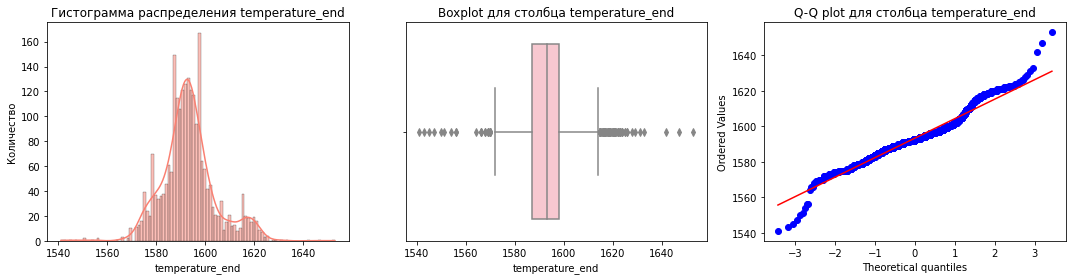

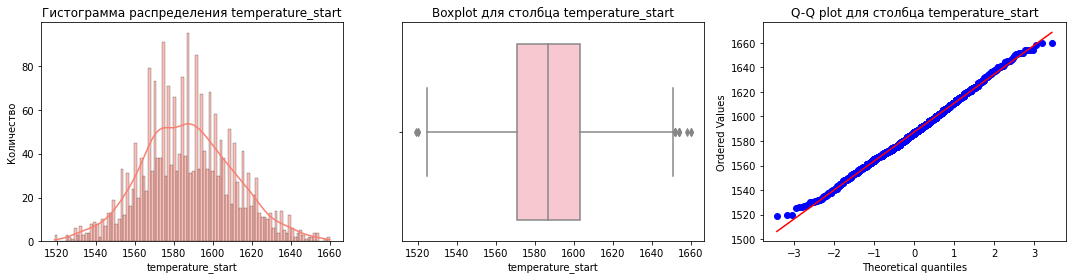

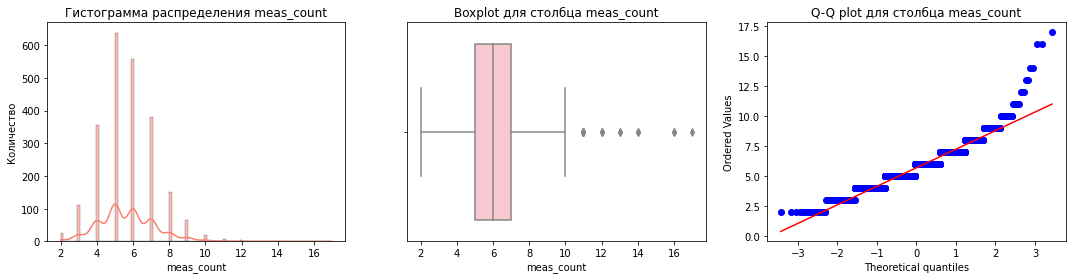

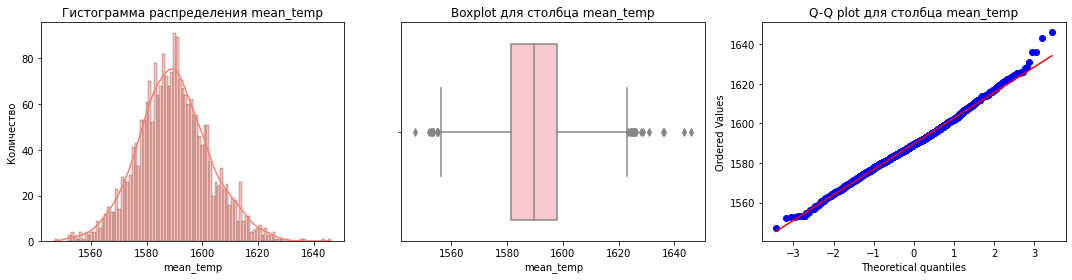

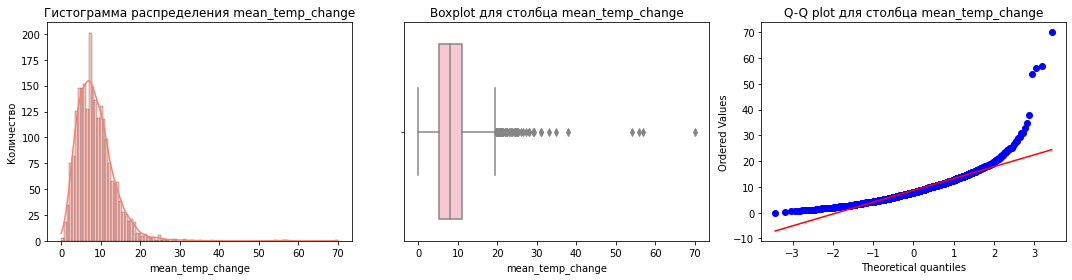

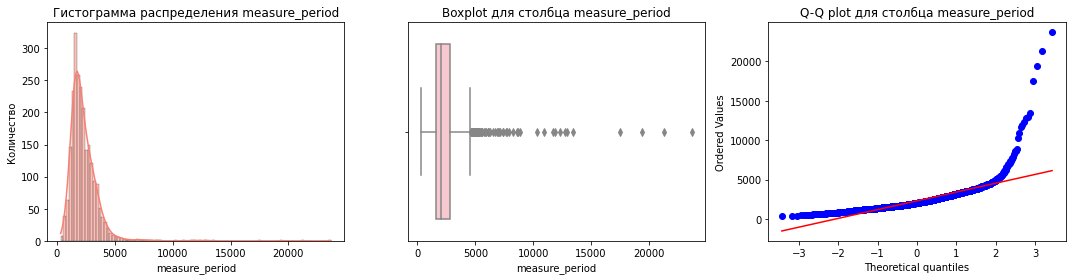

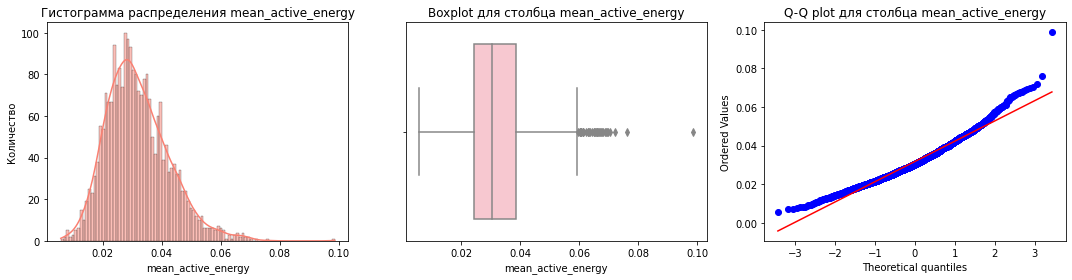

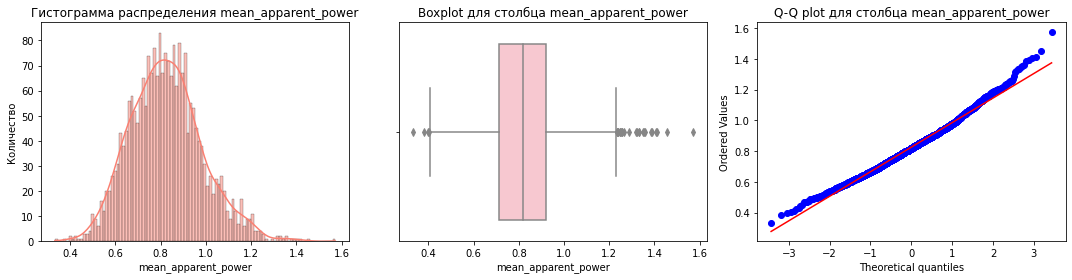

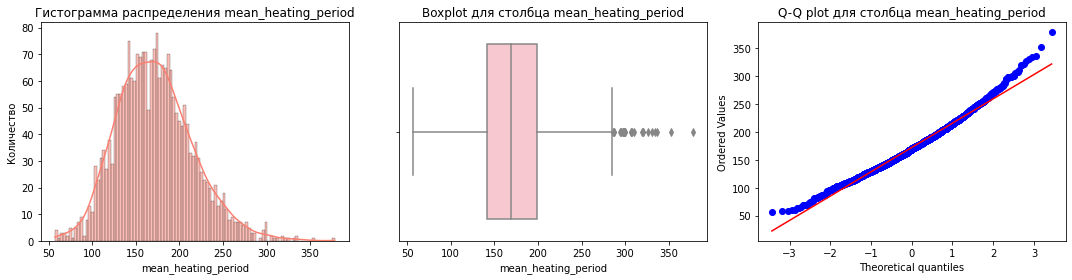

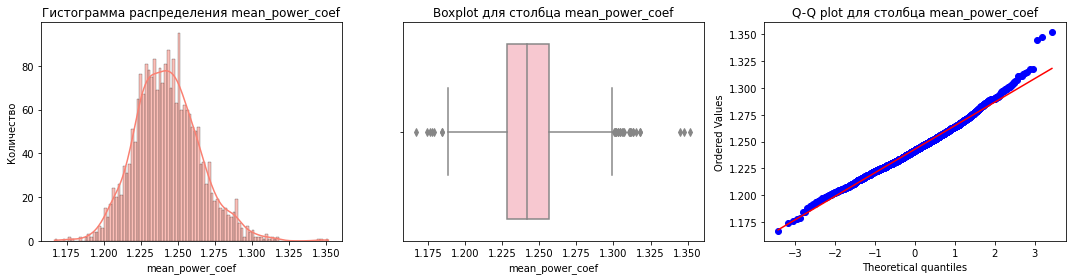

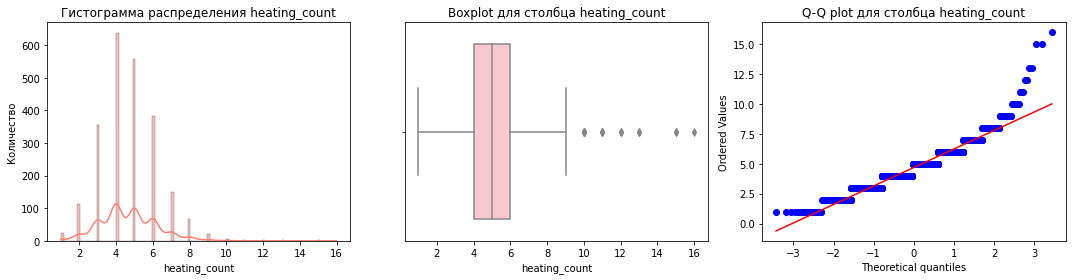

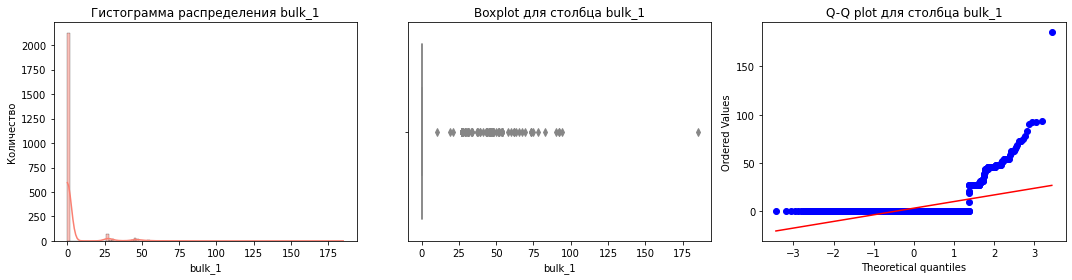

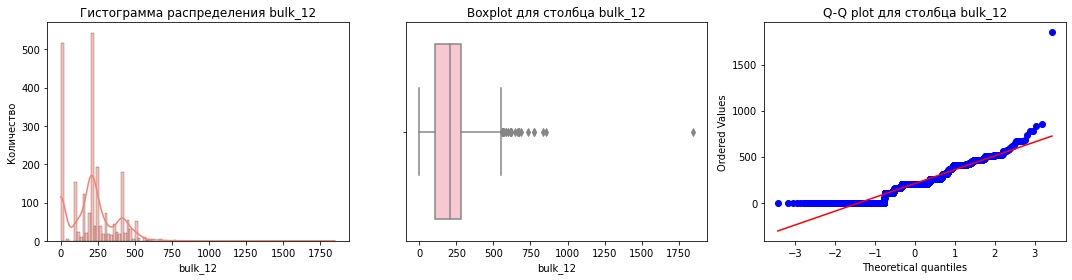

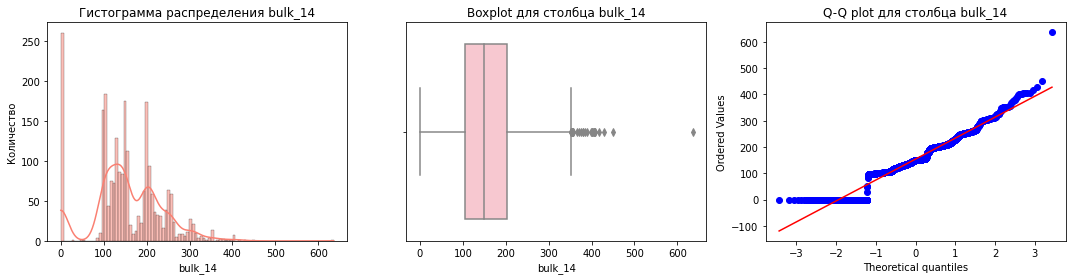

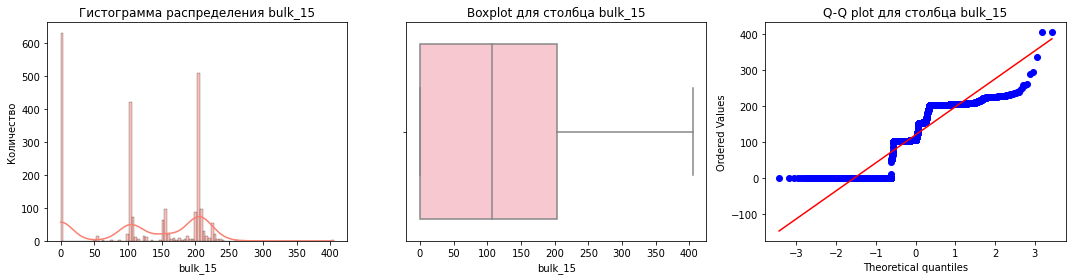

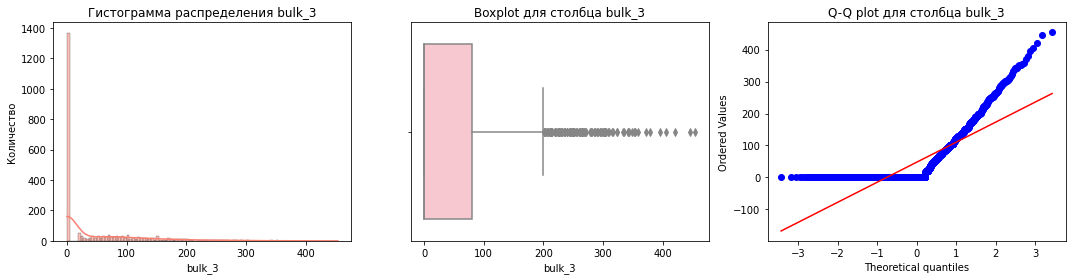

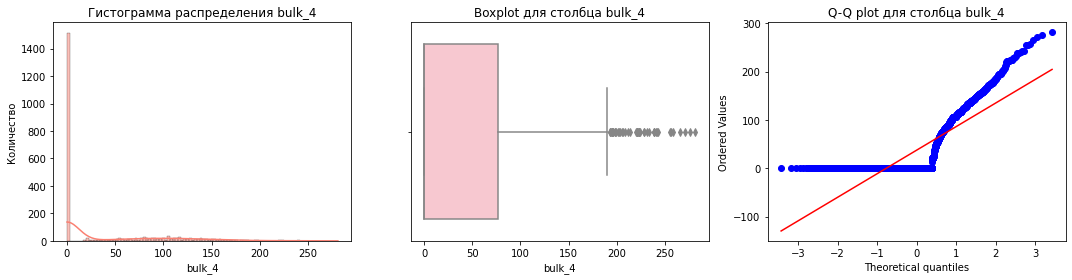

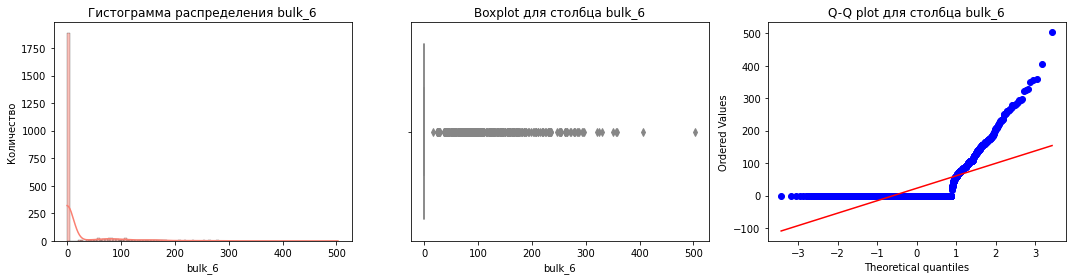

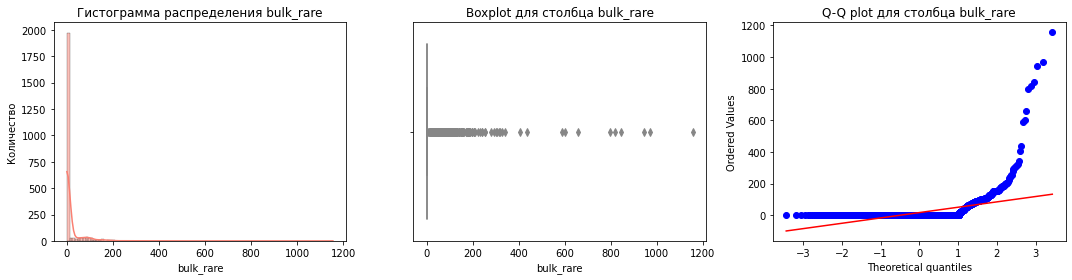

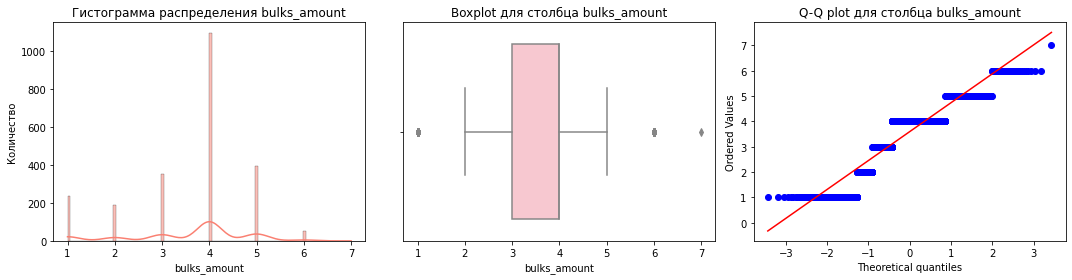

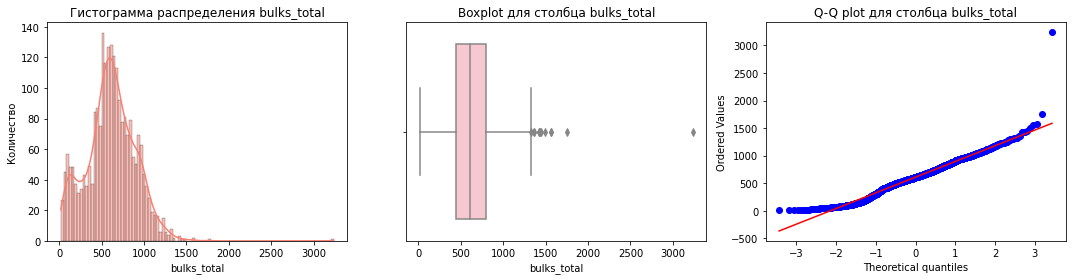

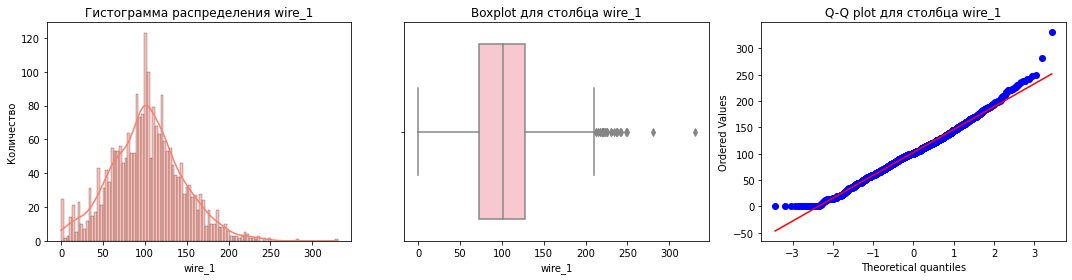

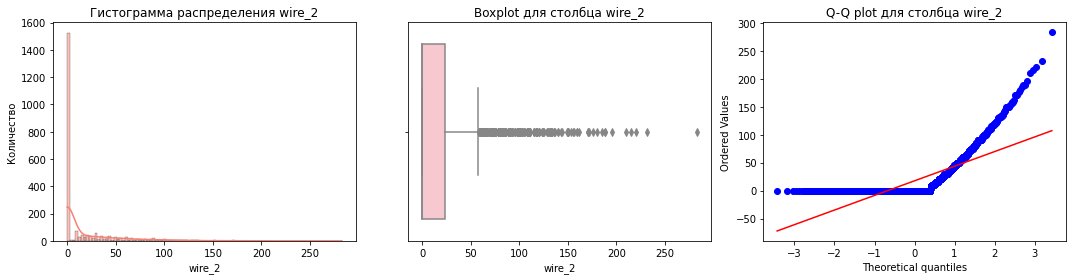

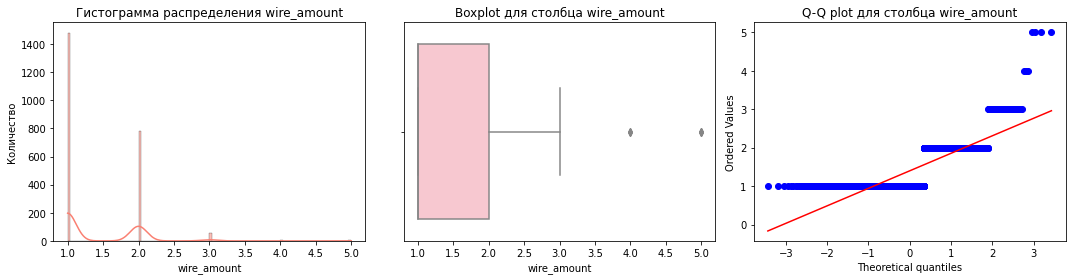

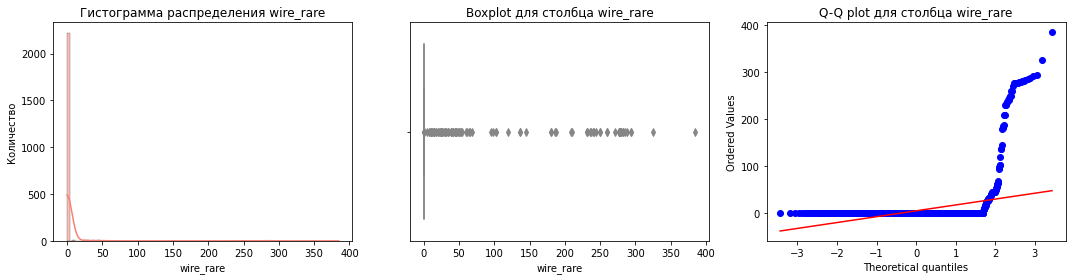

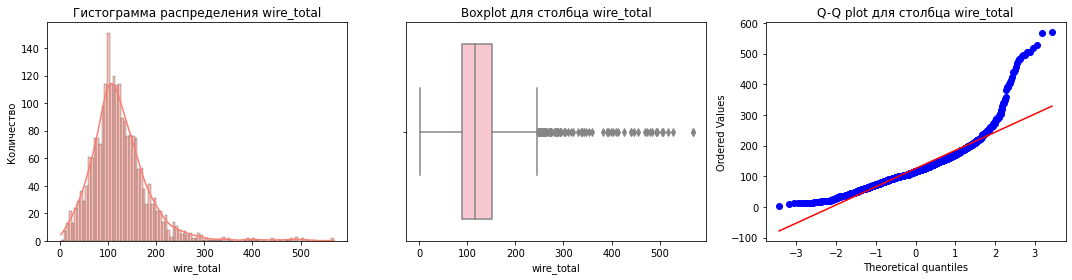

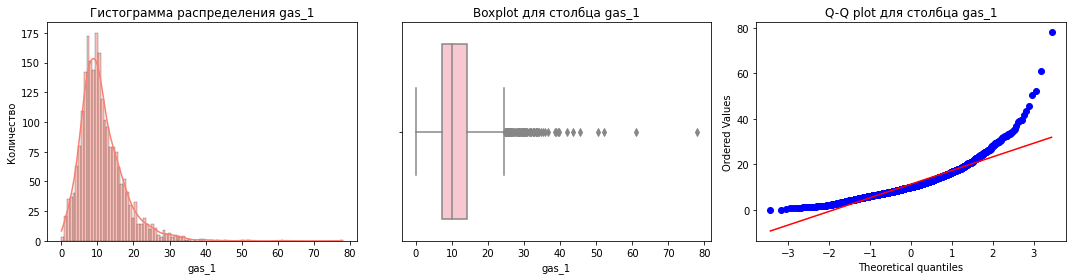

In [208]:
short_dif_graphics(final, 'final')

Природа распределения данных не изменилась: группы редких значений с максимальными показателями, но они имеют естественное происхождение, оставим их в датасете. 

Проверим, соблюдается ли логическое требование о том, что количество измерений температуры всегда больше операций нагрева на 1 (потому что температура измеряется до первого нагрева и после последнего).

In [209]:
((final['meas_count'] - final['heating_count']) == 1).all()

True

Требование выполняется. 

Рассмотрим взаимосвязь признаков с целевым на диаграммах рассеяния.

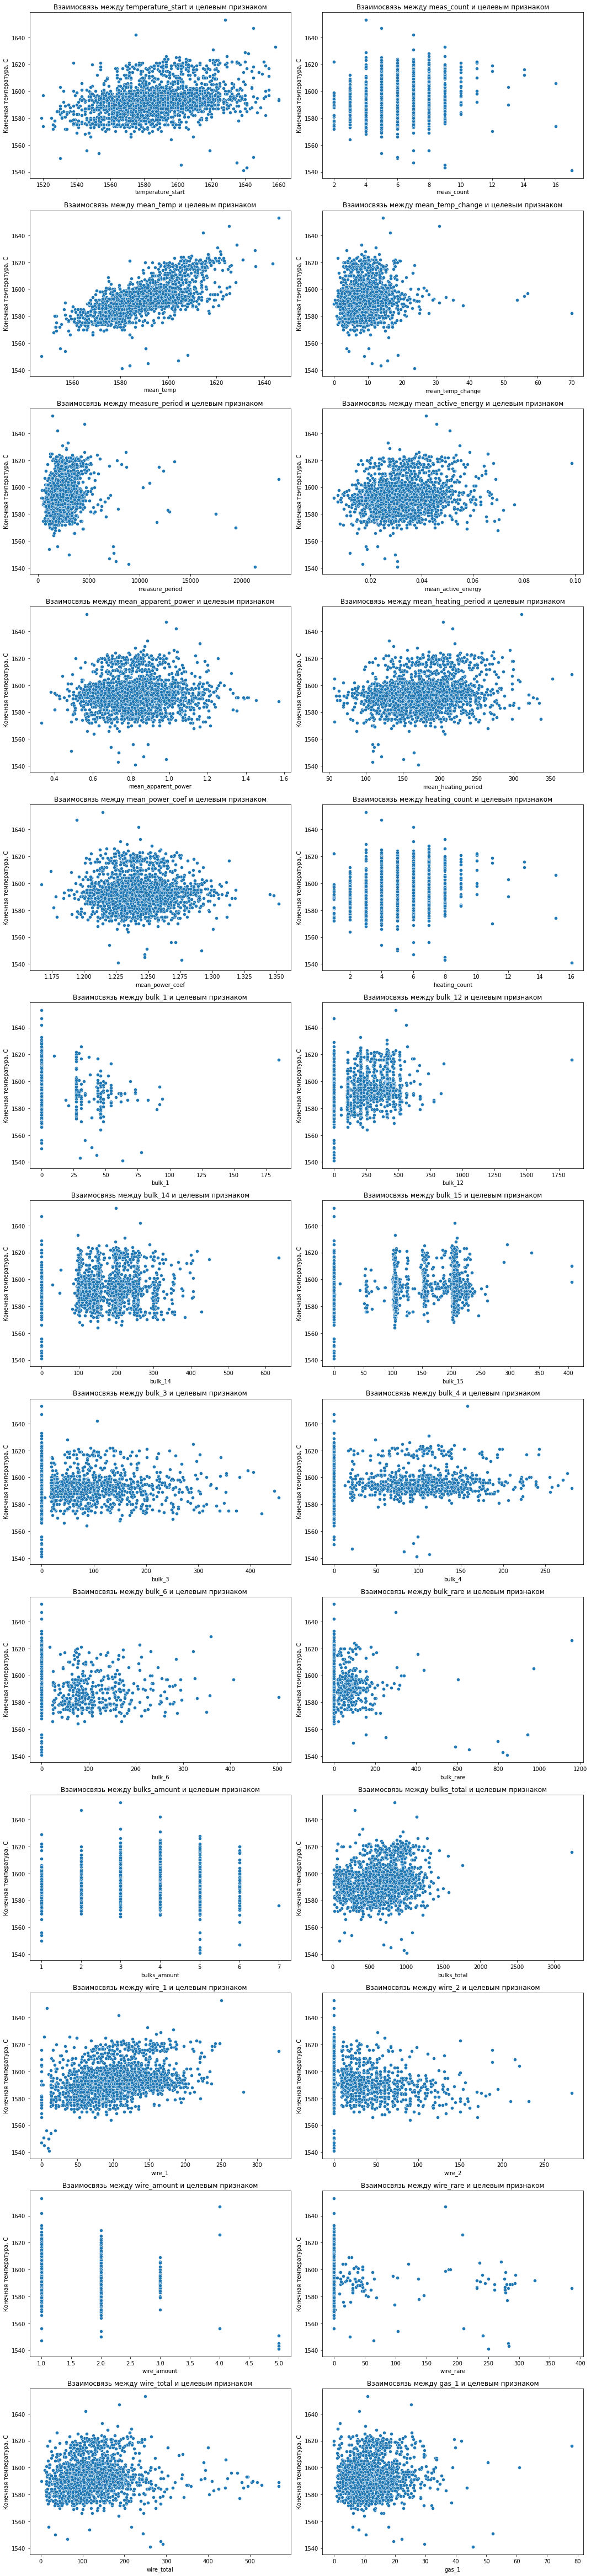

In [210]:
n_cols = 2
features = final.columns.drop(['key', 'temperature_end'])
n_rows = len(features) // n_cols + int(len(features) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

if n_rows == 1:
    axes = axes[np.newaxis, :]

for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols
    sns.scatterplot(ax=axes[row, col], x=final[feature], y=final['temperature_end'])
    axes[row, col].set_title(f'Взаимосвязь между {feature} и целевым признаком')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Конечная температура, С')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

На первый взгляд нелинейных зависимостей конечная температура с признаками не образует, на диаграммах точки распределены в хаотичном порядке, не группируются, но можно заметить линейную связь со средней температурой. 

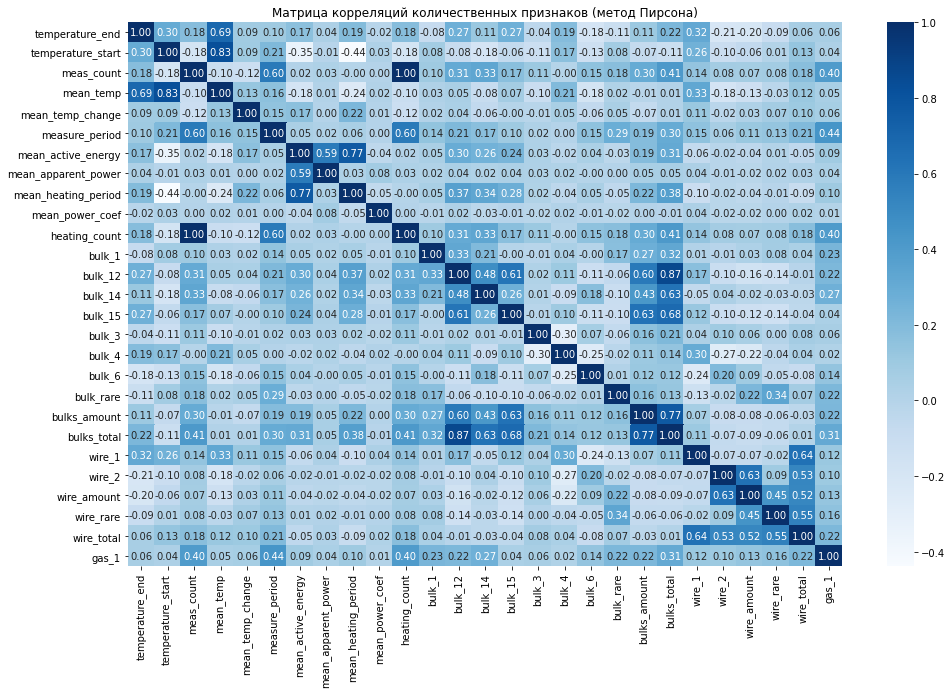

In [211]:
plt.figure(figsize=(16, 10))
sns.heatmap(final.drop('key', axis=1).corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Матрица корреляций количественных признаков (метод Пирсона)', fontdict={'fontsize': 12})
plt.show()

С конечной температурой крепкой взаимосвязью обладают средняя температура, количество использованных проволочных материалов и объем использования редких видов сыпучих и проволочных материалов. Признаки heating_count и meas_count сильно коррелируют друг с другом, что логично, мы уже установили константную разницу между ними. Сильную корреляцию между количеством и объемом использованных редких проволочных материалов также можно объяснить: только два вида из девяти остались в финальных данных, остальные были сгруппированы из-за редкости применения. По корреляции между количеством нагревов и объемом использования сыпучих материалов можно сделать предположение, что они добавляются в сплав неоднократно, небольшими порциями, между собой материалы тоже обладают взаимосвязью, что говорит об их совместном участии в составе. Признаки mean_apparent_power и mean_power_coef демонстрируют самую слабую корреляцию с остальными.

In [212]:
final = final.drop(columns=['mean_temp', 'mean_temp_change', 'meas_count', 'measure_period']).copy()

**ВЫВОД:**

Анализ объединенных данных показал, что некоторые признаки обладают сильной взаимосвязью с конечной температурой. В частности, была обнаружена линейная связь средней температуры с конечной температурой, а также значительное влияние количества использованных проволочных материалов и объема использования редких видов сыпучих и проволочных материалов. Чтобы избежать утечки, мы удалили из исследования данные о средней температуре и среднем ее изменении, а также о полном периоде времени между первым измерением и последним.

Корреляционный анализ указал на наличие мультиколлинеарности между признаками heating_count и meas_count, исключим из данных сведения о количестве измерений, они явно избыточны. Между количеством и объемом использованных редких проволочных материалов также обнаружена сильная взаимосвязь - это объясняется технологическими процессами и особенностями данных. В то же время, признаки mean_apparent_power и mean_power_coef продемонстрировали слабую корреляцию с остальными. Некоторые признаки могут быть слабо связаны с другими признаками, но все же быть важными для предсказания целевого значения. Модель может выявить такие зависимости, которые не очевидны при простом корреляционном анализе, поэтому оставим и после обучения изучим их важность.

Чтобы учесть возможные линейные и нелинейные эффекты можно использовать метод PolynomialFeatures из библиотеки scikit-learn для моделей линейной регрессии. Это позволило более полно учесть влияние комбинаций признаков на целевой. Также задействуем методы регуляризации (например, Lasso или Ridge регрессию), чтобы попробовать автоматически снизить вес незначимых признаков, улучшить обобщающую способность модели и предотвратить переобучение.

## Подготовка данных для обучения моделей <a id="шаг_4"></a>

Удалим ненужные признаки и выделим целевой показатель, после разделим данные на тренировочную и тестовую выборки в пропорции 3:1.

In [213]:
X = final.drop(columns=['key', 'temperature_end'])
y = final['temperature_end']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25, 
    random_state = RANDOM_STATE
)

X_train.shape, X_test.shape

((1743, 22), (582, 22))

Для оценки модели с использованием метрики средней абсолютной ошибки (MAE) создадим оценщик, чтобы использовать его в кросс-валидации при подборе гиперпараметров.

In [215]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

Создадим трансформер для признаков с PolynomialFeatures для моделей линейной регрессии. Чтобы масштабировать данные, используем скейлер - c помощью перебора гиперпараметров выберем один из двух: StandardScaler и MinMaxScaler, так как данные распределены ненормально и содержат выбросы. Из-за того, что трансформация данных требуется только для моделей линейной регрессии, создадим для них отельные пайплайны.

In [217]:
cols_num = ['temperature_start', 
            'heating_count', 'wire_amount', 'bulks_amount',
            'mean_active_energy', 'mean_apparent_power', 'mean_heating_period', 'mean_power_coef',
            'bulk_1', 'bulk_12', 'bulk_14',
            'bulk_15', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_rare', 
            'bulks_total', 'wire_1', 'wire_2', 'wire_rare',
            'wire_total', 'gas_1'
           ]

In [218]:
preprocessing = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ]), cols_num)
    ]
)

In [219]:
pipeline_elasticnet = Pipeline([
    ('preprocessor', preprocessing),
    ('model', ElasticNet(random_state=RANDOM_STATE, max_iter=2000))
])
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessing),
    ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
])
pipeline_ridge = Pipeline([
    ('preprocessor', preprocessing),
    ('model', Ridge(random_state=RANDOM_STATE, max_iter=2000))
])
pipeline = Pipeline([
    ('model', None)  
])

Ridge, Lasso и ElasticNet регрессии были выбраны для оптимизации модели на основании их способностей обрабатывать высокоразмерные данные и справляться с мультиколлинеарностью, а также выявлять наиболее значимые признаки. 
Ridge регрессия (также известная как L2-регуляризация) добавляет штраф за сумму квадратов коэффициентов, что помогает снизить величину коэффициентов и сделать модель более устойчивой к переобучению. Ridge регрессия хорошо справляется с мультиколлинеарностью, сглаживая коэффициенты и предотвращая чрезмерное влияние сильно коррелирующих признаков. Lasso регрессия (также известная как L1-регуляризация) способна выполнять отбор признаков, обнуляя незначимые коэффициенты.
ElasticNet сочетает в себе свойства Ridge и Lasso регрессий, объединяя L1 и L2 штрафы. Это позволяет учитывать как регуляризацию, так и отбор признаков. ElasticNet полезна, когда данные содержат много признаков, некоторые из которых могут быть коррелированы или незначимы. 

Помимо моделей линейной регрессии обучим два алгоритма градиентного бустинга: CatBoostRegressor и LightGBM, а также RandomForestRegressor - ансамбль деревьев решений. Все три модели являются методами ансамблевого обучения, которые объединяют результаты множества базовых моделей (обычно деревьев решений) для улучшения общей производительности. Эти модели способны захватывать сложные нелинейные зависимости между признаками и целевой переменной.

Подготовим функцию для для вычисления метрик RMSE, MAPE и R², чтобы получить полное представление о качестве лучшей модели.

In [220]:
def metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    r2 = r2_score(y_test, y_pred)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'R²: {r2:.2f}')

RMSE даст нам представление о средней величине ошибки предсказаний: эта метрика больше акцентирует внимание на крупных ошибках, тогда как MAE дает более общее представление об ошибках модели.
MAPE позволит понять точность модели в процентах, т.е. на сколько процентов предсказания модели отличаются от фактических.
R² покажет, насколько хорошо модель объясняет вариацию в данных, чем ближе к 1, тем точнее модель соответствует данным.

## Обучение моделей <a id="шаг_5"></a>

Для поиска лучших гиперпараметров используем GridSearchCV, данные будут разделены на 5 фолдов. 

Для моделей линейной регрессии попробуем разные уровни регуляризации, степени полиномиальных признаков и скейлеры, отдельно для  Еlasticnet попробуем разный баланс между l1 и l2 регуляризациями. 

Для RandomForestRegressor выберем оптимальное количество деревьев в лесу и использование бутстреппинга при построении деревьев: True - каждое дерево строится на случайной подвыборке с возвращением, False - каждый пример в обучающей подвыборке будет выбран только один раз - в наших условиях небольшого объема данных лучше оценить оба подхода. 

В обучении алгоритма LGBMRegressor попробуем разные количества итераций, скорость обучения, максимальное количество листьев в одном дереве и разные степени регуляризации.

Для CatBoostRegressor также попробуем разные количества итераций и глубины дерева.



In [120]:
param_grid_final = [
    {
        'model': [pipeline_ridge],
        'model__model__alpha': [0.01, 0.1, 1.0],
        'model__preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__preprocessor__num__poly__degree': [1, 2]
    },
    {
        'model': [pipeline_elasticnet],
        'model__model__alpha': [0.01, 0.1, 1.0],
        'model__model__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
        'model__preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__preprocessor__num__poly__degree': [1, 2]
    },
    {
        'model': [pipeline_lasso],
        'model__model__alpha': [0.01, 0.1, 1.0],
        'model__preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__preprocessor__num__poly__degree': [1, 2]
    },
    {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [500, 1000],
        'model__bootstrap': [True, False]
    },
    {
        'model': [LGBMRegressor(metric='mae', random_state=RANDOM_STATE)],
        'model__n_estimators': [1000, 1500],
        'model__learning_rate': [0.001, 0.01],
        'model__num_leaves': range(9, 12),
        'model__reg_lambda': [0.1, 0.5]
    },
    {
        'model': [CatBoostRegressor(logging_level='Silent', loss_function='MAE', eval_metric='MAE', random_state=RANDOM_STATE)],
        'model__iterations': [500, 1500],
        'model__depth': [3, 6]
    }
]


gs = GridSearchCV(
    pipeline,  
    param_grid_final,  
    cv=5,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train, y_train)

print(f'Лучшая метрика MAE на кросс-валидации: {-gs.best_score_:.2f}')
print(f'Лучшая модель: {gs.best_estimator_}')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Лучшая метрика MAE на кросс-валидации: 6.16
Лучшая модель: Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x000001C39A719690>)])


In [121]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(gs.cv_results_) 
result['mean_test_score'] = result['mean_test_score']*-1
result['name'] = result['params'].apply(lambda x: x['model'].__class__.__name__ if not isinstance(x['model'], Pipeline) else x['model'].steps[-1][1].__class__.__name__)

def format_params(params):
    model_name = params['model'].__class__.__name__ if not isinstance(params['model'], Pipeline) else params['model'].steps[-1][1].__class__.__name__
    formatted_params = []

    if 'model__model__alpha' in params:
        formatted_params.append(f"alpha={params['model__model__alpha']}")
    if 'model__model__l1_ratio' in params:
        formatted_params.append(f"l1_ratio={params['model__model__l1_ratio']}")

    if 'model__preprocessor__num__scaler' in params:
        formatted_params.append(f"scaler={params['model__preprocessor__num__scaler'].__class__.__name__}")
    if 'model__preprocessor__num__poly__degree' in params:
        formatted_params.append(f"degree={params['model__preprocessor__num__poly__degree']}")

    if 'model__learning_rate' in params:
        formatted_params.append(f"learning_rate={params['model__learning_rate']}")
    if 'model__n_estimators' in params:
        formatted_params.append(f"n_estimators={params['model__n_estimators']}")
    if 'model__num_leaves' in params:
        formatted_params.append(f"num_leaves={params['model__num_leaves']}")
    if 'model__depth' in params:
        formatted_params.append(f"depth={params['model__depth']}")
    if 'model__iterations' in params:
        formatted_params.append(f"iterations={params['model__iterations']}")
    if 'model__l2_leaf_reg' in params:
        formatted_params.append(f"l2_leaf_reg={params['model__l2_leaf_reg']}")
    if 'model__bootstrap' in params:
        formatted_params.append(f"bootstrap={params['model__bootstrap']}")

    return f"{model_name}({', '.join(formatted_params)})"

result['short_params'] = result['params'].apply(format_params)

best_results = (
    result.loc[result.groupby('name')['mean_test_score'].idxmin()]
    [['rank_test_score', 'name', 'short_params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
    .sort_values('rank_test_score')
)


best_results

rank_test_score                   name  \
113                1      CatBoostRegressor   
100                2          LGBMRegressor   
11                17                  Ridge   
75                18                  Lasso   
31                19             ElasticNet   
85                52  RandomForestRegressor   

                                                            short_params  \
113                          CatBoostRegressor(depth=3, iterations=1500)   
100   LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=9)   
11                       Ridge(alpha=1.0, scaler=MinMaxScaler, degree=2)   
75                      Lasso(alpha=0.01, scaler=MinMaxScaler, degree=2)   
31   ElasticNet(alpha=0.01, l1_ratio=0.9, scaler=MinMaxScaler, degree=2)   
85              RandomForestRegressor(n_estimators=1000, bootstrap=True)   

     mean_test_score  mean_fit_time  mean_score_time  
113         6.163225       3.375916         0.007401  
100         6.218502       2.888040         0.014203  
11          6.299380       0.048005         0.008600  
75          6.312310       0.189216         0.015802  
31          6.359032       0.239510         0.015403  
85          6.608934      27.104926         0.224217

Для всех моделей метрики подходят под требование заказчика (МАЕ < 6.8), но мы еще не показывали моделям тестовые данные. CatBoostRegressor с параметрами depth=3, iterations=1500 показал наилучшие результаты на кросс-валидации. С небольшим отставанием по значению метрики хороший результат демонстрирует LGBMRegressor. Неплохо себя проявили модели линейной регрессии с полиномиальными комбинациями признаков во 2 степени, к тому же среднее время обучения у них в несколько раз меньше, чем у алгоритмов градиентного спуска. На последнем месте оказалась модель RandomForestRegressor, помимо самой большой метрики МАЕ, она обучается дольше всех.

## Тестирование лучшей модели <a id="шаг_6"></a>

In [122]:
best_model = gs.best_estimator_

In [231]:
best_model = CatBoostRegressor(depth=3, iterations=1500, logging_level='Silent', loss_function='MAE', eval_metric='MAE', random_state=RANDOM_STATE)

In [232]:
%%time
best_model.fit(X_train, y_train)

CPU times: user 1.87 s, sys: 116 ms, total: 1.99 s
Wall time: 2.8 s


In [233]:
%%time
y_pred=best_model.predict(X_test)

CPU times: user 2.95 ms, sys: 213 µs, total: 3.17 ms
Wall time: 2 ms


In [234]:
mean_absolute_error(y_test, y_pred)

5.873252443323938

In [235]:
metrics(y_test, y_pred)

RMSE: 8.34
MAPE: 0.37%
R²: 0.46


В среднем предсказания модели отклоняются от фактических значений на 5.87 градусов, в процентном соотношении - на 0,37%. Модель объясняет только 46% вариации данных, т.е. 46% разброса фактических значений можно объяснить признаками, используемыми в модели.

Посмотрим, как распределяется разница между предсказанными и фактическими значениями.

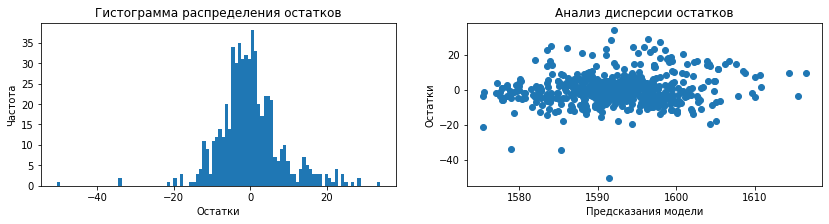

In [236]:
residuals = y_test - y_pred
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
axes[0].hist(residuals, bins=100)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()

Остатки распределены равномерно около нуля, значительных систематических ошибок нет. Некоторые паттерны в данных модель не смогла уловить, поэтому мы видим ряд значений на хвостах гистограммы, но скорее всего модель просто не справилась с выбросами в данных. Судя по нескольким точкам в нижнем левом углу диаграммы рассеяния, модель плохо предсказывает низкие значения конечной температуры.  
Посмотрим как соотносятся реальные и предсказанные значения на графике.

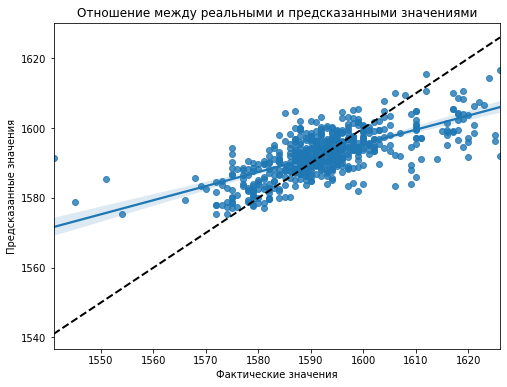

In [237]:
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred)
plt.ylabel('Предсказанные значения')
plt.xlabel('Фактические значения')
plt.title('Отношение между реальными и предсказанными значениями')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

При идеальном качестве предсказания точки на графике лежали бы на черной линии - линии функции у=х. Регрессионная голубая линия - тенденция между предсказанными и реальными значениями, на графике ее наклон не совпадает с черной линией - модель склонна завышать низкие значения и занижать высокие, но большая группа значений в центре находится вокруг линии у=х.

Рассмотрим, какие признаки вносят наибольший вклад в предсказания.

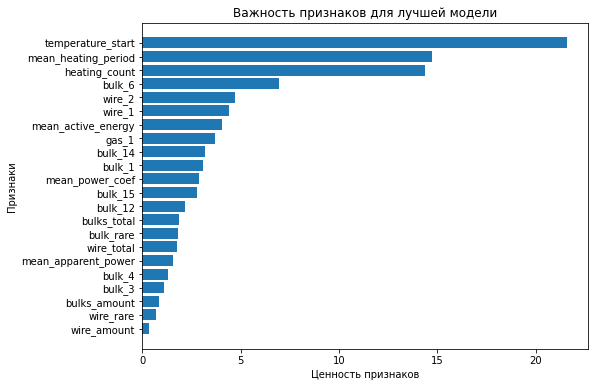

In [238]:
model_best =best_model

importance = model_best.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importance
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Признак'], importance_df['Важность'])
plt.xlabel('Ценность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для лучшей модели')
plt.gca().invert_yaxis()
plt.show()

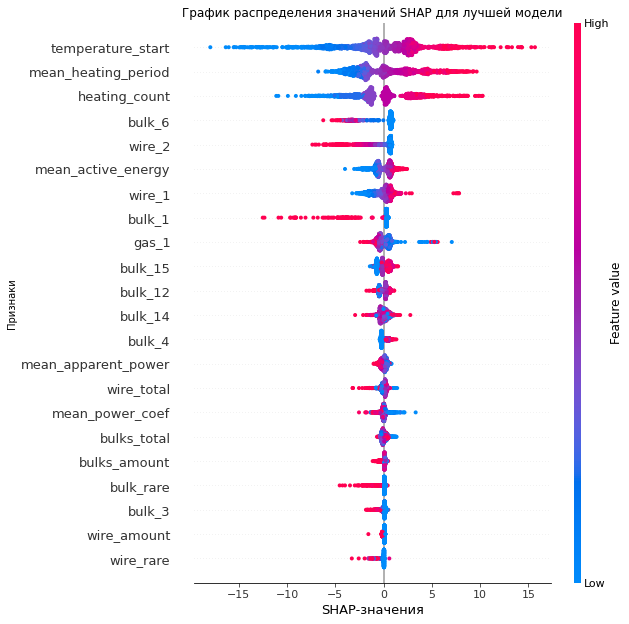

In [239]:
explainer_cat = shap.TreeExplainer(model_best)
shap_values_cat = explainer_cat(X_train)
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values_cat, max_display=25, show=False)
ax.set_xlabel('SHAP-значения')
ax.set_ylabel('Признаки')
ax.set_title('График распределения значений SHAP для лучшей модели')
plt.show()

Сильнее всего влияют начальная температура, количество операций нагрева и среднее время нагрева. Чем большее значение имеют эти признаки, тем больше предсказанная температура и наоборот. Чем больше сыпучего материала bulk_6 было добавлено в сплав, тем меньшим будет предсказанное значение. Такое же правило работает с общим временем обработки партии стали, bulk_1 и wire_2. Средняя потребленная активная энергия также в списке важных признаков, возможно из-за содержания в себе времени выполнения нагрева при небольшой дисперсии активной мощности. Наименьшее влияние на предсказание имеют количество использованных проволочных и сыпучих материалов, а также группы редких добавок. 

Сравним качество предсказаний с базовой моделью DummyRegressor.

In [240]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)

y_pred_dummy = dummy_reg.predict(X_test)
print(f'Метрика MAE на тестовой выборке при использовании базовых предсказаний среднего значения: {mean_absolute_error(y_test, y_pred_dummy)}')

Метрика MAE на тестовой выборке при использовании базовых предсказаний среднего значения: 8.214044198393962


Если бы мы использовали в качестве предсказания среднюю конечную температуру стали, то в среднем ошибались бы на 8,21 градусов. Наша модель лучше справляется с задачей предсказания по сравнению с простым использованием среднего значения.

## Общий вывод и рекомендации <a id="шаг_7"></a>

Для оптимизации производственного процесса и снижения потребления электроэнергии была выбрана лучшая модель для предсказания температуры сплава. Модель CatBoostRegressor показала хороший результат на тестовых данных: MAE 5.87 (предсказания модели отклоняются от фактических значений на 5.87 °C), что соответствует требуемому уровню точности. Ключевые признаки, которые оказали наибольшее влияние на предсказания, включают начальную температуру, количество операций нагрева, среднее время нагрева, а также объем и количество использованных сыпучих и проволочных материалов.

Анализ данных выявил несколько значительных проблем. Начиная с партии 2500 (после 14:04 10.08.2019), были зафиксированы пропуски в данных по температуре: фиксируются только результаты самого первого измерения. Это нарушение сбора данных требует внимания и корректировки для обеспечения полноты и точности информации. Кроме того, была обнаружена аномалия в значении реактивной мощности, что могло быть вызвано ошибкой на этапе сбора данных. Для корректировки этой аномалии была использована модель линейной регрессии. Также были выявлены партии с критически низкими начальными температурами, которые скорее всего были бракованными и были исключены из анализа.

Чаще всего значения температуры внутри партии отличаются от предыдущего на +/- 25 °C, при этом самые распространенные величины этой разницы сгруппированы около нуля, что указывает на стабильность процесса с небольшими колебаниями температуры. Однако есть строки со значительными изменениями: в одном случае наблюдается резкий нагрев на 81 °C, а в других случаях разница составляет от -25 до -96 °C, что свидетельствует о резком охлаждении и бесполезной теплопотере.

Поскольку начальная температура оказывает значительное влияние на конечную температуру процесса, представляется целесообразным улучшить контроль температуры нагреваемой стали на предыдущем этапе производства и уменьшить теплопотери при транспортировке стали от предыдущего этапа до ковша. Это должно способствовать обеспечению постоянных начальных условий нагрева и, как следствие, повышению качества прогнозирования. Однако не только начальная температура вносит вклад в предсказания. Важными также являются количество операций нагрева, среднее время нагрева и объемы использованных сыпучих и проволочных материалов, которые влияют на конечную температуру процесса.

Для уменьшения разброса в измерениях температуры необходимо установить границы нормальных колебаний и фиксировать случаи, когда температура выходит за эти границы. Это позволит своевременно реагировать на отклонения и корректировать процесс, что в свою очередь повысит стабильность и качество продукции.

Таким образом, улучшение контроля температуры на всех этапах производства, снижение теплопотерь и внедрение систем для фиксации аномальных температурных колебаний помогут оптимизировать производственные расходы и повысить точность прогнозирования, обеспечивая более стабильное качество продукции.